# <center>Data Mining Project Code</center>

** **
## <center>*02 - XXXXXXXX*</center>

** **

Consumers today are becoming more selective about where they buy their products and where they spend their money. Consequently, it is essencial for companies to better understand their clients, being able to tailor sales and discounts to certain groups of customers.

Knowing this, the goal of this project is to divide customers of `ABCDEats Inc.` into smaller groups, whose clients have similar characteristics and purchasing behaviours.

The second  notebook of this project consists of the .......

This project was presented to the `TargetSphere Advisors`, a group of Consultants, Business Analysts and Data Scientists who focus on delivering Customer Segementation solutions for small and medium-sized businesses.

The members of the `team` are:
- Ana Farinha  - 20211514
- António Oliveira - 20211595
- Mariana Neto - 20211527
- Salvador Domingues - 20240597


# Table of Contents

<a class="anchor" id="top"></a>


1. [Importing Libraries & Data](#1.-Importing-Libraries-&-Data) <br><br>
2. [Data Cleansing](#2.-Data-Cleansing) <br><br>
    2.1 [Filling the missing values](#2.1-Filling-the-missing-values) <br><br>
    2.2 [Outlier Treatment](#2.2-Outlier-Treatment)<br><br>
3. [Feature Selection](#-3.-Feature-Selection)<br><br>
    3.1 [Univariate variables](#3.1.-Univariate-variables)<br><br>
    3.2 [Spearman Correlation](#3.2-Spearman-Correlation)


 

# 1. Importing Libraries & Data

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# To fill the missing values
from sklearn.impute import KNNImputer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Import external '.py' file containing the functions created and used for this analysis
import functions as f

In [2]:
dataset_name = 'preprocessed_data'

data = pd.read_csv(f'data/{dataset_name}.csv', index_col = "customer_id")
data.head(3)

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,HR_18_ratio,HR_19_ratio,HR_20_ratio,HR_21_ratio,HR_22_ratio,HR_23_ratio,0_7h,8_14h,15_19h,20_23h
customer_id,,,,,,,,,,,,,,,,,,,,,
1b8f824d5e,2360,18.0,2,5,1,0,1,DELIVERY,DIGI,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0,2,0
5d272b9dcb,8670,17.0,2,2,2,0,1,DISCOUNT,DIGI,12.82,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,0
f6d1b2ba63,4660,38.0,1,2,2,0,1,DISCOUNT,CASH,9.20,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,0


In [3]:
data['customer_region'] = data['customer_region'].replace(0, '0000')

In [4]:
data['customer_region'] = data['customer_region'].astype(str)

In [5]:
data['customer_region'].unique()

array(['2360', '8670', '4660', '2440', '0000', '4140', '2490', '8370',
       '8550'], dtype=object)

<br>

# 2. Data Cleansing

## 2.1 Filling the missing values

In the previous notebook, we noticed that there were 3 columns with missing values: `customer_age`, `first_order` and `HR_0`. For the feature `first_order` we considered filling the missing values with 0, given that in these rows the last order had values of 0, meaning that the customer made their first and last order on the day that the dataset started. The last variable was deleted, since new features were created. Previously, we used the median for the feature `customer_age`, but in this notebook we will fill with the K nearest neighbor imputer.

In [6]:
# pd.set_option('display.max_rows', None)

In [7]:
# data.isna().sum()

From the output above we can see that there are missing values in `avg_order_hour` and `days_between`, the reason for this is because for 235 customers there is no values in the hours feature.

**customer_age**

First, we are going to check the variables that have a higher correlation with `customer_age`. Doing this, we can use these variables to predict the missing value using the KNN Imputer.

numeric_data = data.select_dtypes(include=['int64', 'float64'])
final_data = numeric_data.loc[:, ~(numeric_data.isin([0, 1]).all())]

corr = final_data.corr(method="pearson")

# Selecting correlations for 'customer_age'
target_variable = 'customer_age'
if target_variable in corr:
    correlations = corr[target_variable].dropna()

    most_correlated = correlations.abs().sort_values(ascending=False)

    print("Most correlated variables with customer_age:")
    print(most_correlated)
else:
    print(f"'{target_variable}' is not in the numeric dataset.")

# Selecting the top 6 correlated variables
top_correlated = most_correlated[1:7].index.tolist()

# Creating a new DataFrame with only the most correlated variables
selected_data = data[top_correlated + ['customer_age']]

# Applying KNN Imputer only to these variables
knn_imputer = KNNImputer(n_neighbors=10)
imputed_data = knn_imputer.fit_transform(selected_data)

# Replacing the imputed values in the original DataFrame
data['customer_age'] = imputed_data[:, selected_data.columns.get_loc('customer_age')].round().astype(int)

data['customer_age'].isna().sum()

<br>

**first_order**

Given the insights taken on the previous notebook, we will replace all missing values of the feature `first_order` to 0.

data['first_order'] = data['first_order'].fillna(0)

<br>

**days_between**

Since the days_between variable has missing values due to first_order, and we filled the missing values in first_order with 0, the days_between will also be 0, as the last_order is 0 when first_order was initially missing.

data['days_between'] = data['days_between'].fillna(0)

<br>

**avg_order_hour**

numeric_data = data.select_dtypes(include=['int64', 'float64'])
final_data = numeric_data.loc[:, ~(numeric_data.isin([0, 1]).all())]

corr = final_data.corr(method="pearson")

# Selecting correlations for 'avg_order_hour'
target_variable = 'avg_order_hour'
if target_variable in corr:
    correlations = corr[target_variable].dropna()

    # Sorting in descending order by absolute value
    most_correlated = correlations.abs().sort_values(ascending=False)

    print("Most correlated variables with avg_order_hour:")
    print(most_correlated)
else:
    print(f"'{target_variable}' is not in the numeric dataset.")

# Selecting the top 5 correlated variables 
top_correlated = most_correlated[1:6].index.tolist()

# Creating a new DataFrame with only the most correlated variables
selected_data = data[top_correlated + ['avg_order_hour']]

# Applying KNN Imputer only to these variables
knn_imputer = KNNImputer(n_neighbors=10)
imputed_data = knn_imputer.fit_transform(selected_data)

# Replacing the imputed values in the original DataFrame
data['avg_order_hour'] = imputed_data[:, selected_data.columns.get_loc('avg_order_hour')]

print(data['avg_order_hour'].isna().sum())

<br>

## 2.2 Outlier Treatment

Based on the feature distributions analyzed in the previous notebook, we identified the need to address the presence of outliers. However, since many features contain a significant number of zeros - such as customers who never made a purchase (e.g., `product_count = 0` or `vendor_count = 0`) - we will exclude these zero values in this step for most of the features. This approach will allow us to focus on the true distribution of the data and effectively identify outliers.

In [8]:
data_copy = data.copy()

<br>

1. *`vendor_count`*

We first checked the distribution without the zero values in the respective feature.

In [9]:
vendor_filter = data_copy[(data_copy['vendor_count'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


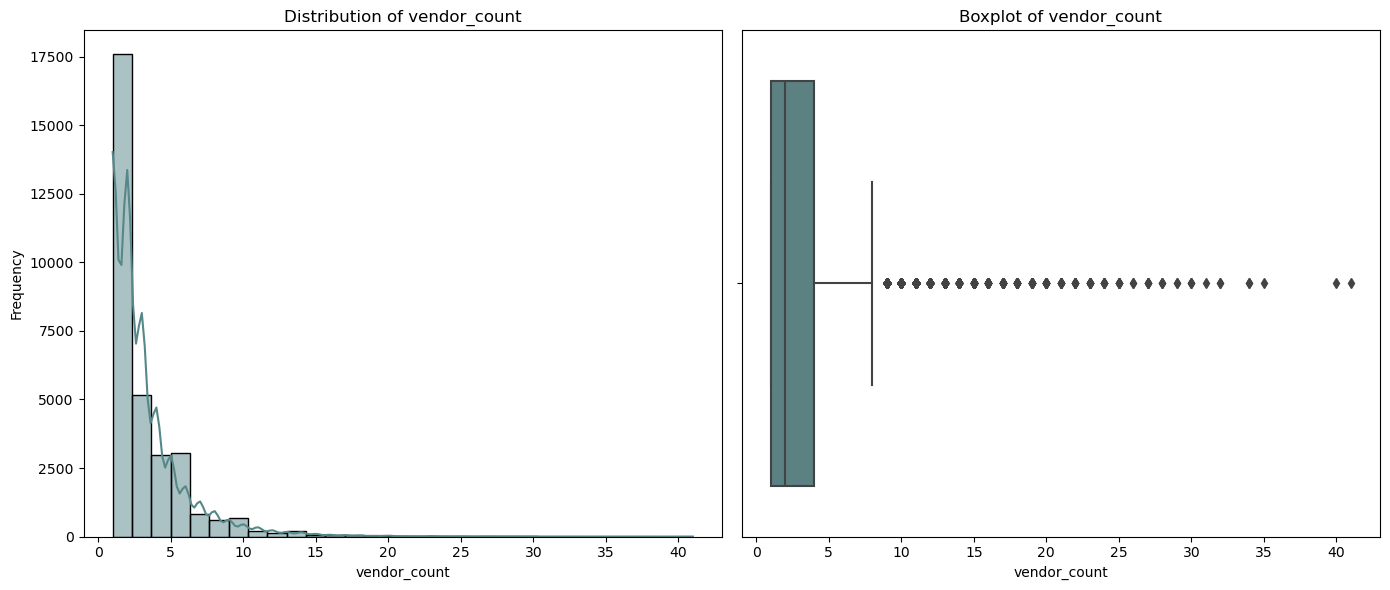

In [10]:
f.plot_distribution_and_boxplot(vendor_filter, 'vendor_count')

Based on the data distribution, we considered individuals with values higher than 34 as outliers, in this feature.

In [11]:
data_copy = data_copy[data_copy['vendor_count'].lt(34)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


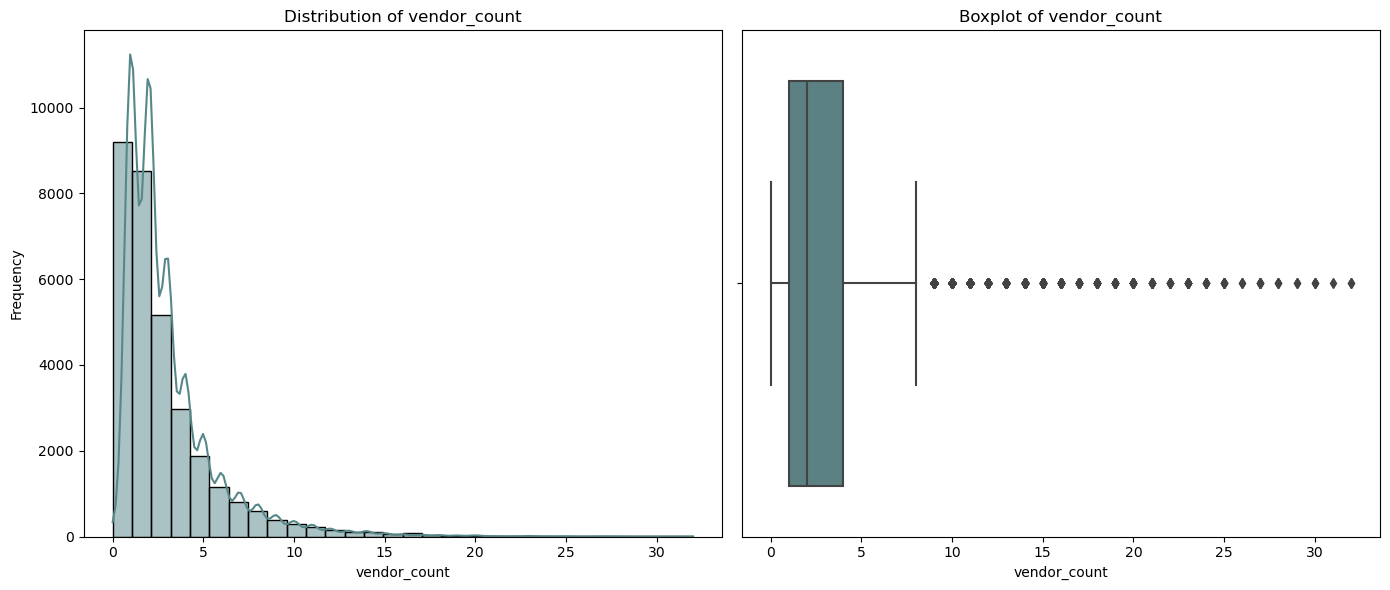

In [12]:
f.plot_distribution_and_boxplot(data_copy, 'vendor_count')

2. *`product_count`*

We first checked the distribution without the zero values in the respective feature.

In [13]:
product_filter = data_copy[(data_copy['product_count'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


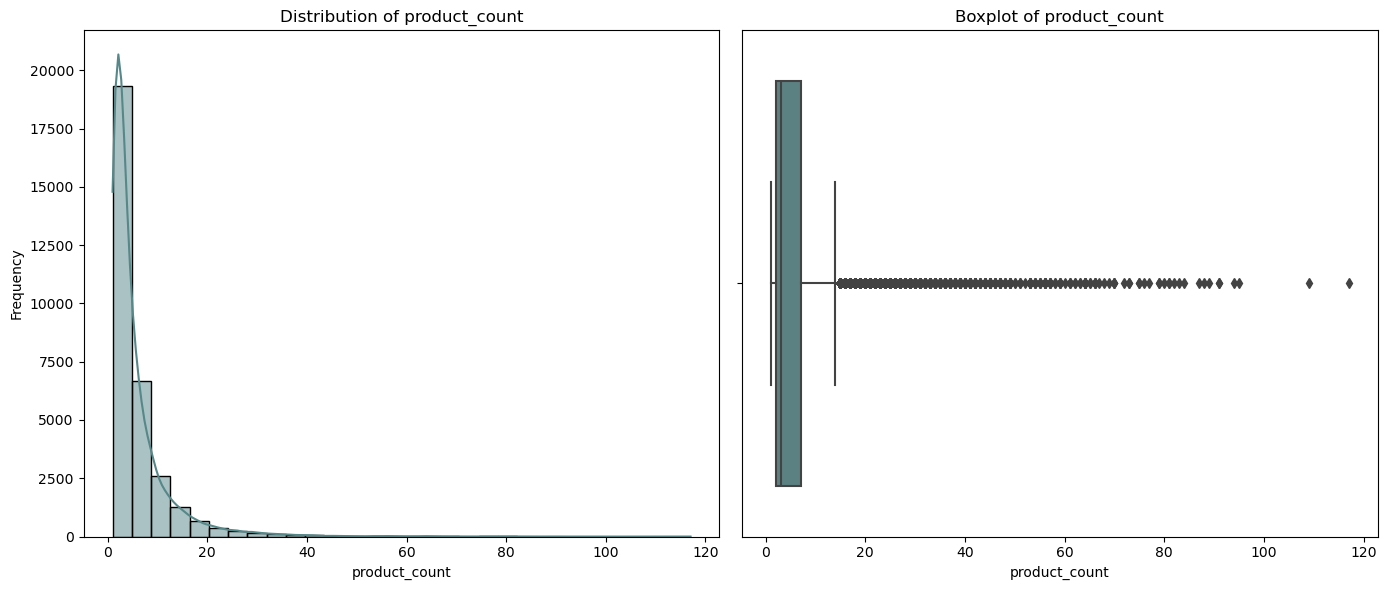

In [14]:
f.plot_distribution_and_boxplot(product_filter, 'product_count')

Based on the data distribution, we considered individuals with values higher than 70 as outliers, in this feature.

In [15]:
data_copy = data_copy[data_copy['product_count'].lt(70)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


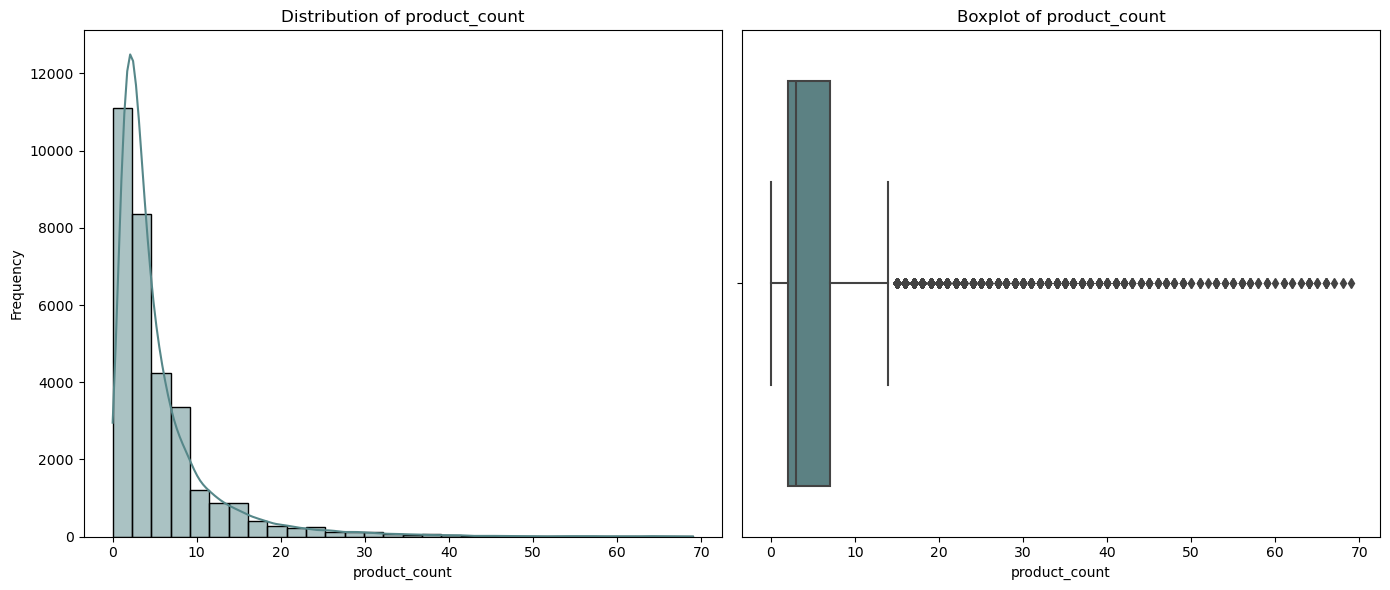

In [16]:
f.plot_distribution_and_boxplot(data_copy, 'product_count')

3. *`is_chain`*

We first checked the distribution without the zero values in the respective feature.

In [17]:
is_chain_filter = data_copy[(data_copy['is_chain'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


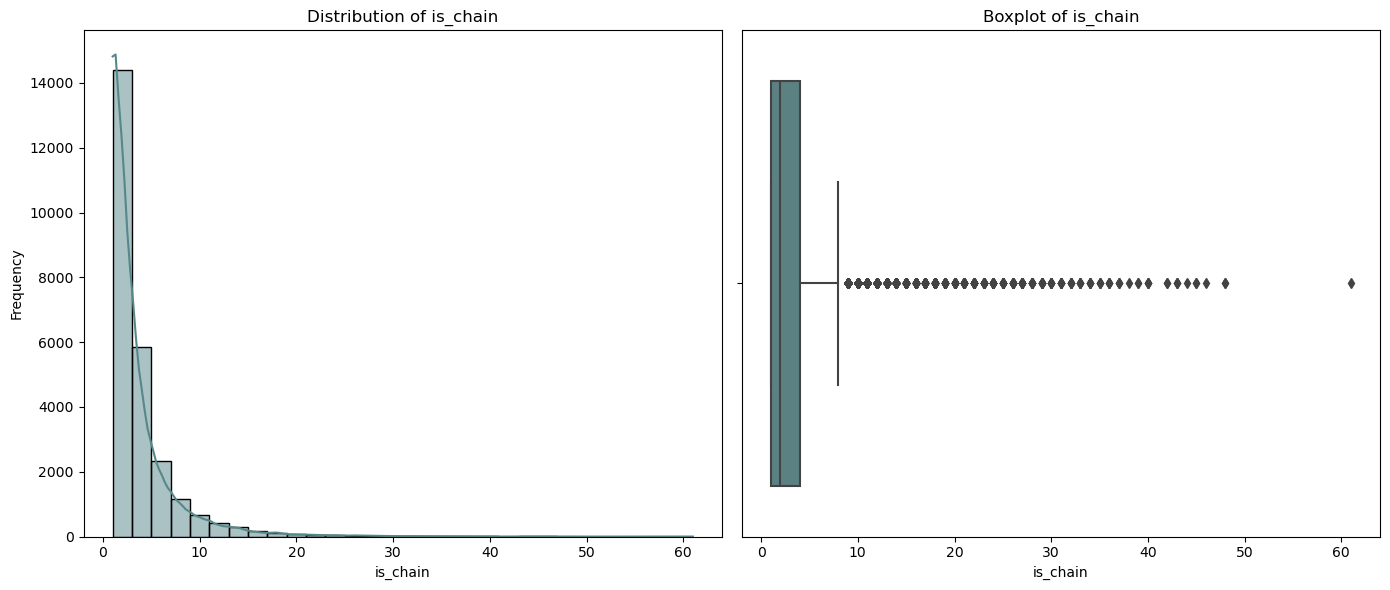

In [18]:
f.plot_distribution_and_boxplot(is_chain_filter, 'is_chain')

Based on the data distribution, we considered individuals with values higher than 42 as outliers, in this feature.

In [19]:
data_copy = data_copy[data_copy['is_chain'].lt(42)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


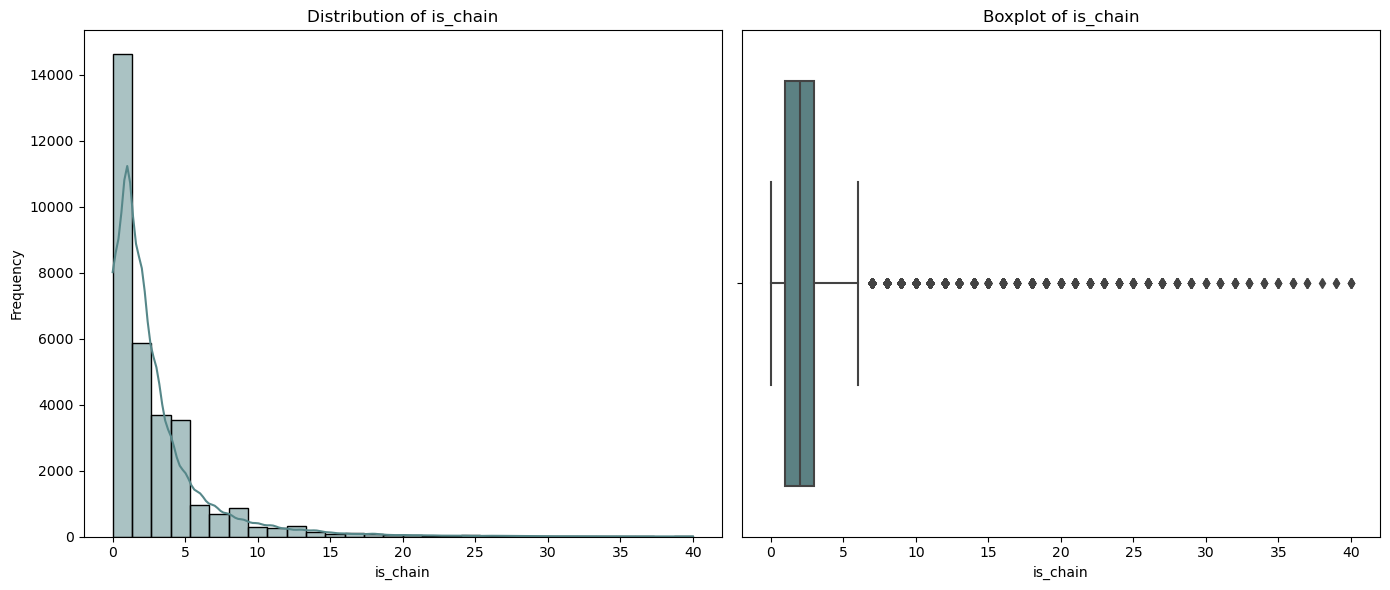

In [20]:
f.plot_distribution_and_boxplot(data_copy, 'is_chain')

4. *`CUI_American`*

We first checked the distribution without the zero values in the respective feature.

In [21]:
cui_american_filter = data_copy[(data_copy['CUI_American'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


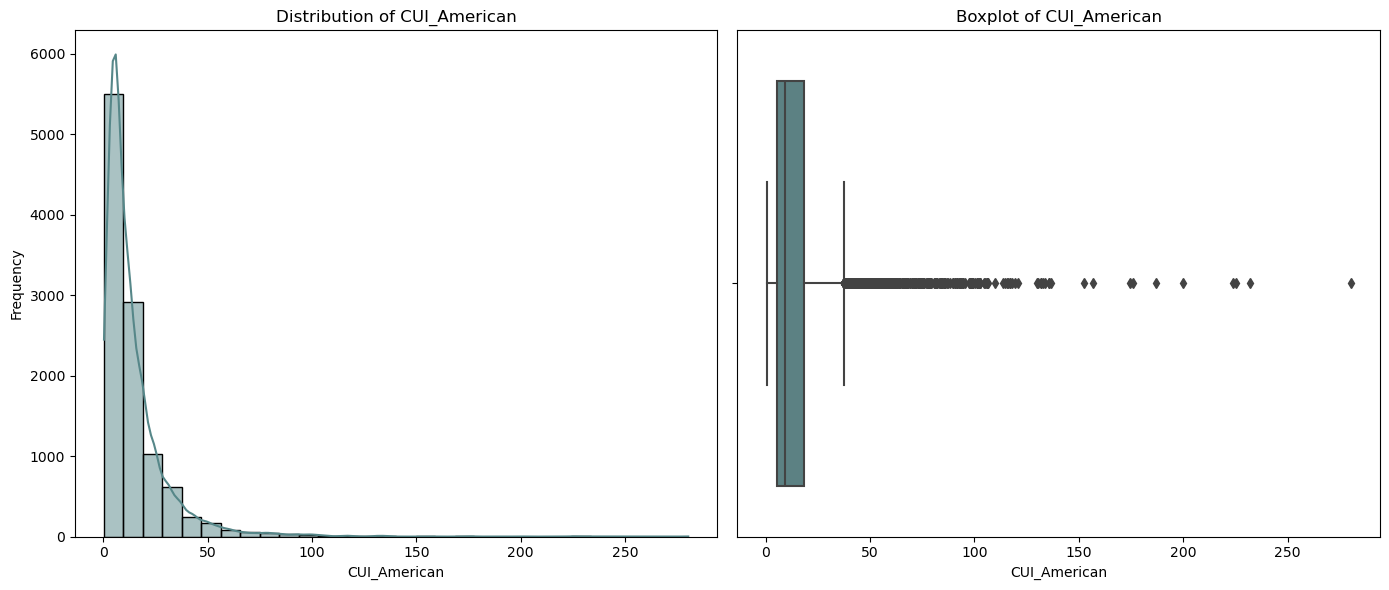

In [22]:
f.plot_distribution_and_boxplot(cui_american_filter, 'CUI_American')

Based on the data distribution, we considered individuals with values higher than 105 as outliers, in this feature.

In [23]:
data_copy = data_copy[data_copy['CUI_American'].lt(105)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


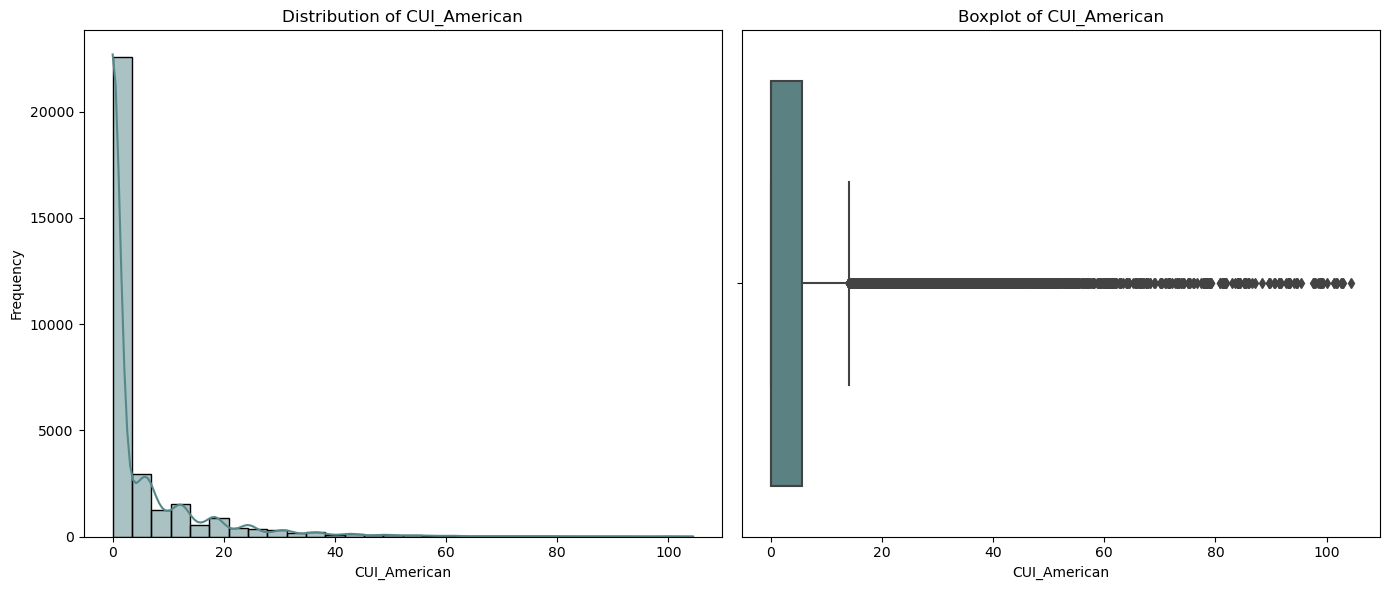

In [24]:
f.plot_distribution_and_boxplot(data_copy, 'CUI_American')

5. *`CUI_Asian`*

We first checked the distribution without the zero values in the respective feature.

In [25]:
cui_asian_filter = data_copy[(data_copy['CUI_Asian'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


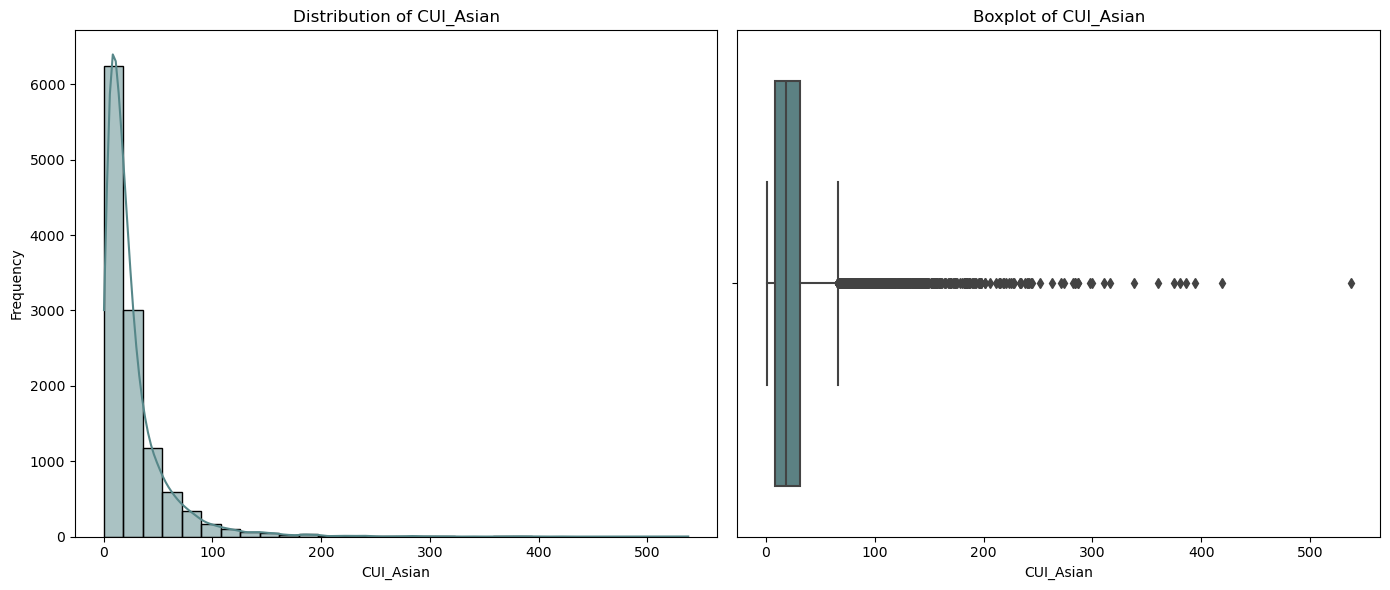

In [26]:
f.plot_distribution_and_boxplot(cui_asian_filter, 'CUI_Asian')

Based on the data distribution, we considered individuals with values higher than 200 as outliers, in this feature.

In [27]:
data_copy = data_copy[data_copy['CUI_Asian'].le(200)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


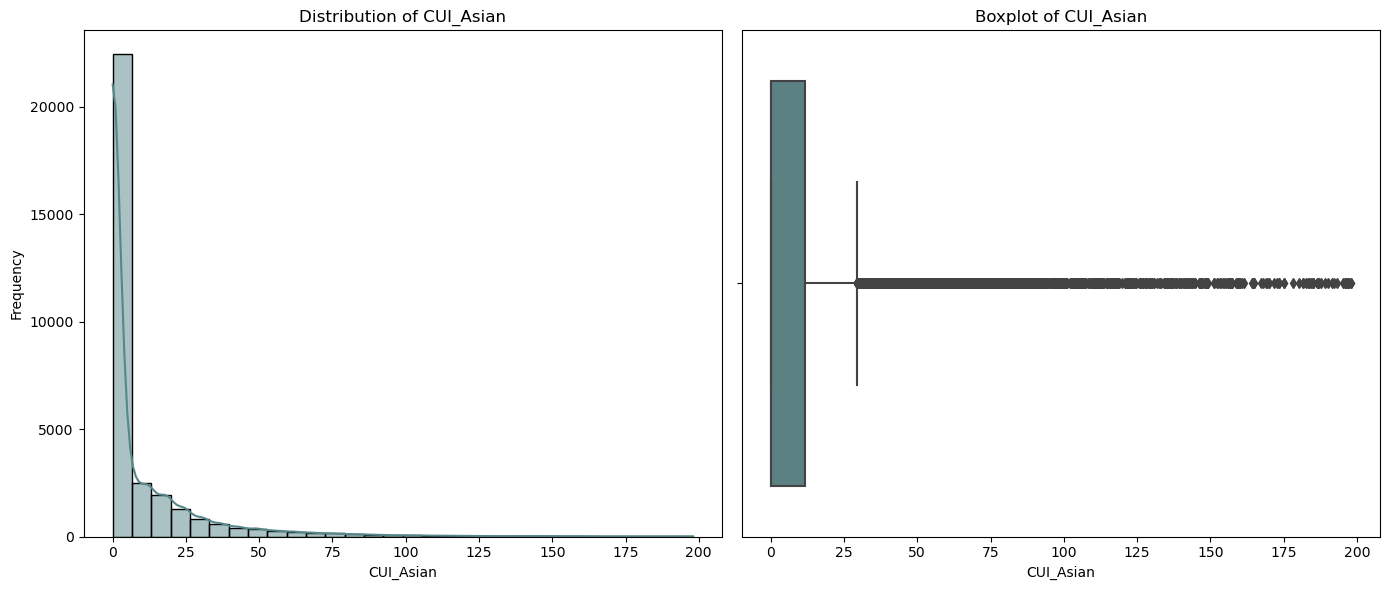

In [28]:
f.plot_distribution_and_boxplot(data_copy, 'CUI_Asian')

6. *`CUI_Beverages`*

We first checked the distribution without the zero values in the respective feature.

In [29]:
cui_beverages_filter = data_copy[(data_copy['CUI_Beverages'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


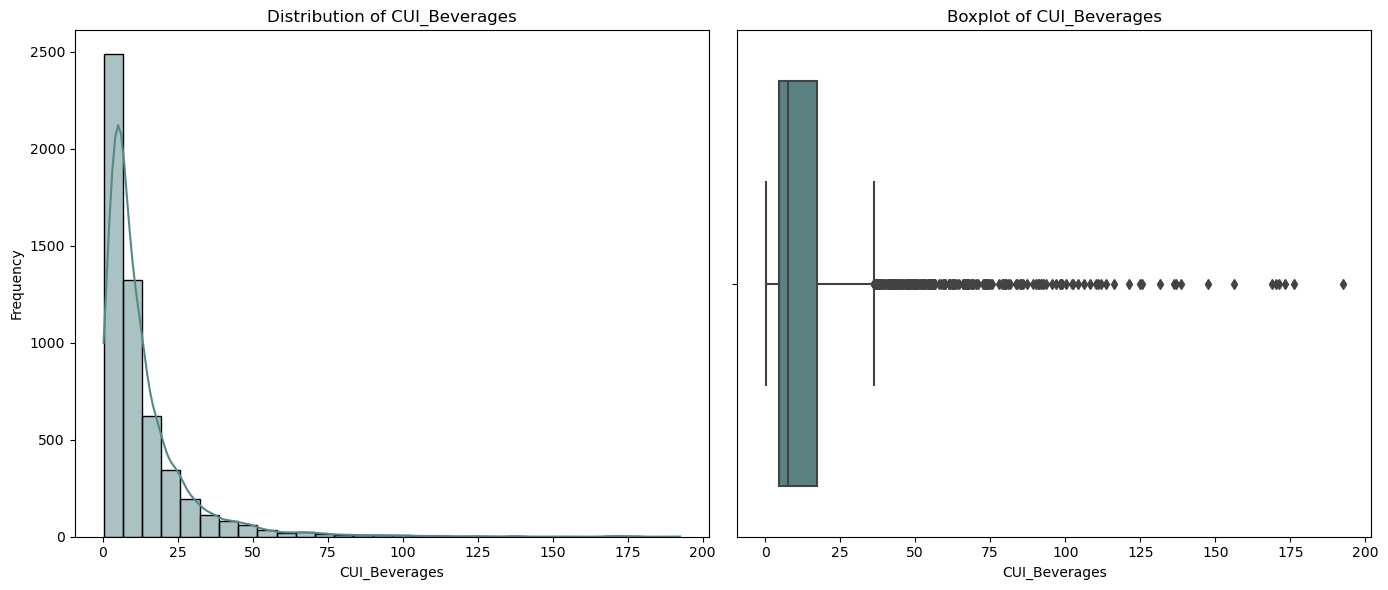

In [30]:
f.plot_distribution_and_boxplot(cui_beverages_filter, 'CUI_Beverages')

Based on the data distribution, we considered individuals with values higher than 75 as outliers, in this feature.

In [31]:
data_copy = data_copy[data_copy['CUI_Beverages'].le(75)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


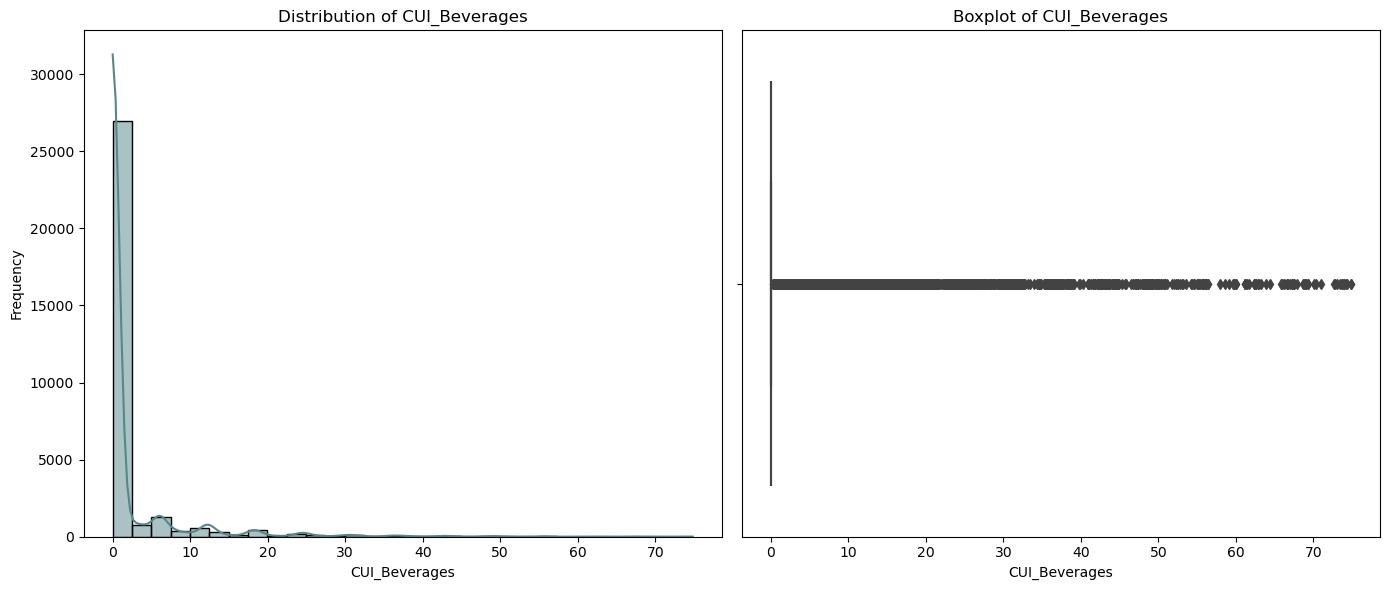

In [32]:
f.plot_distribution_and_boxplot(data_copy, 'CUI_Beverages')

7. *`CUI_Cafe`*

We first checked the distribution without the zero values in the respective feature.

In [33]:
cui_cafe_filter = data_copy[(data_copy['CUI_Cafe'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


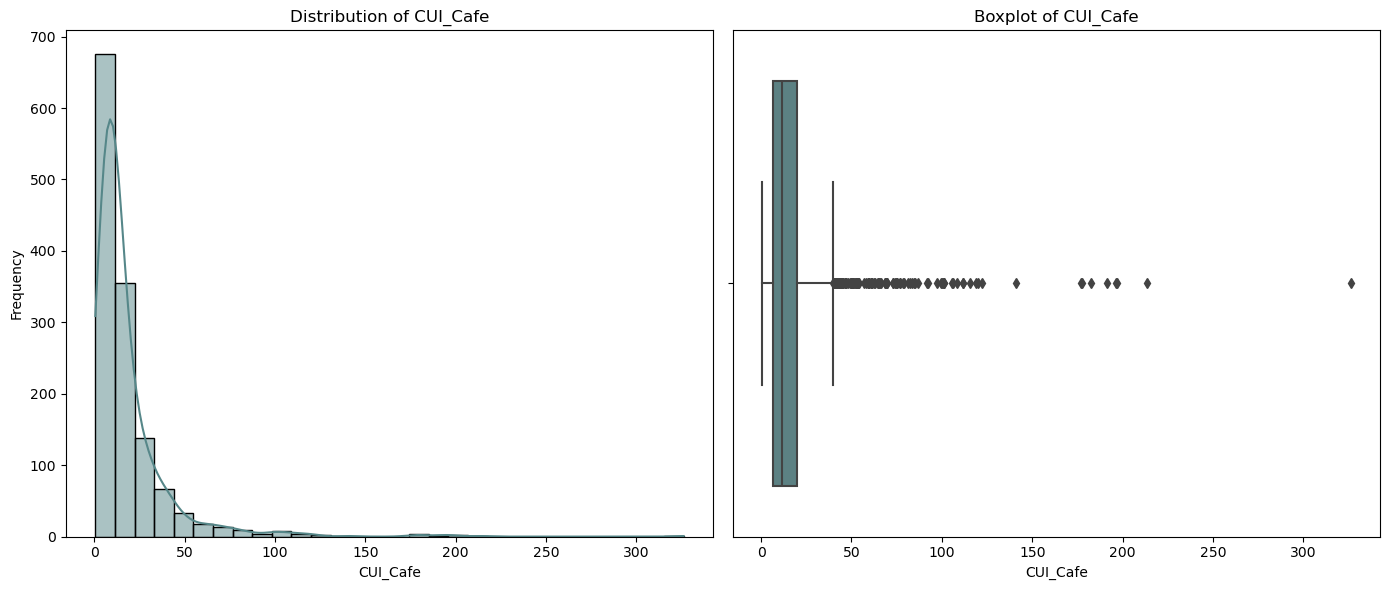

In [34]:
f.plot_distribution_and_boxplot(cui_cafe_filter, 'CUI_Cafe')

Based on the data distribution, we considered individuals with values higher than 55 as outliers, in this feature.

In [35]:
data_copy = data_copy[data_copy['CUI_Cafe'].lt(55)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


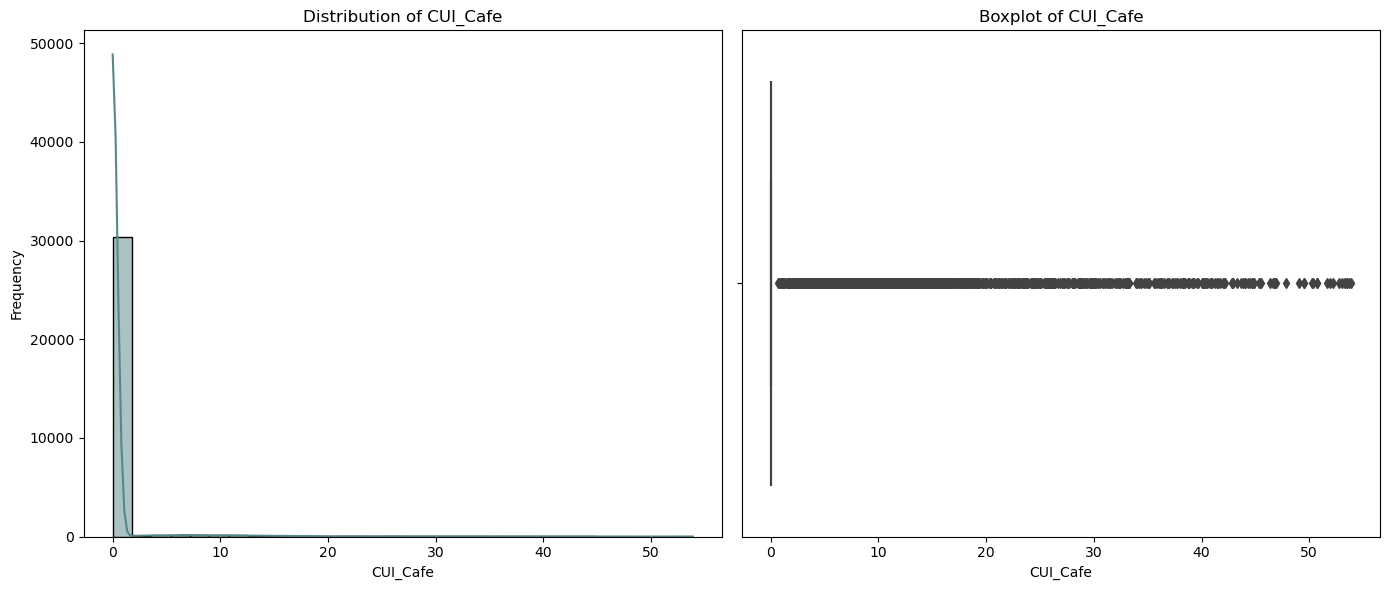

In [36]:
f.plot_distribution_and_boxplot(data_copy, 'CUI_Cafe')

8. *`CUI_Chicken Dishes`*

We first checked the distribution without the zero values in the respective feature.

In [37]:
cui_chicken_filter = data_copy[(data_copy['CUI_Chicken Dishes'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


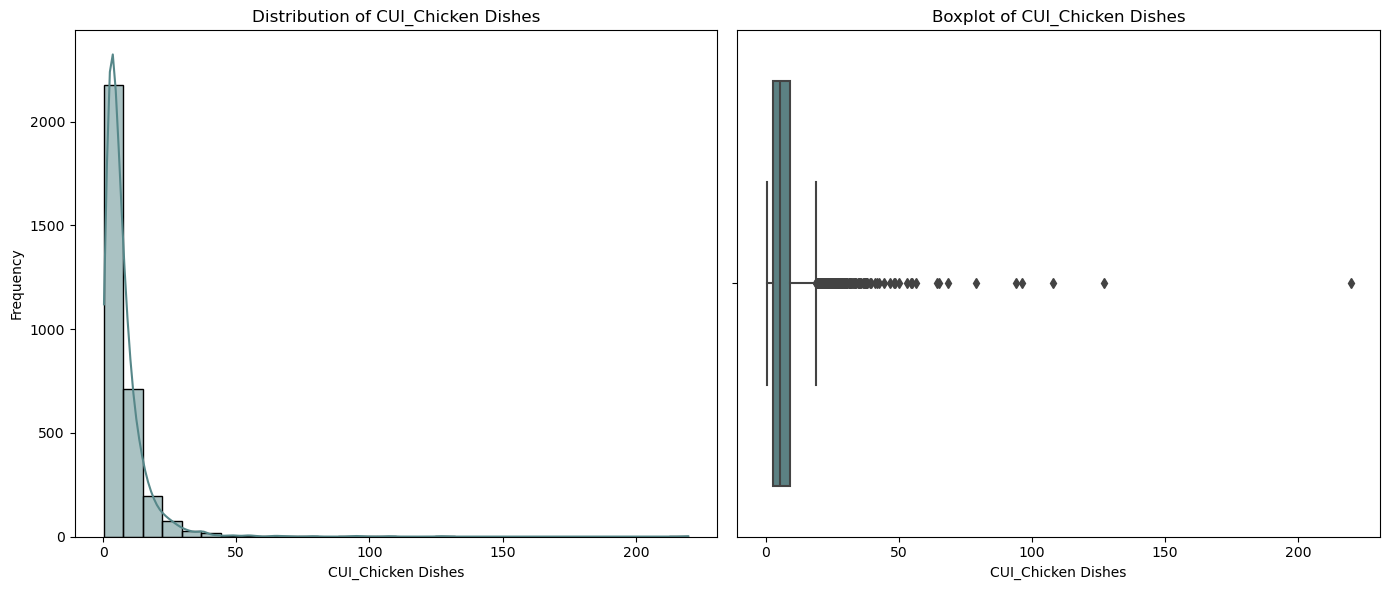

In [38]:
f.plot_distribution_and_boxplot(cui_chicken_filter, 'CUI_Chicken Dishes')

Based on the data distribution, we considered individuals with values higher than 39 as outliers, in this feature.

In [39]:
data_copy = data_copy[data_copy['CUI_Chicken Dishes'].lt(39)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


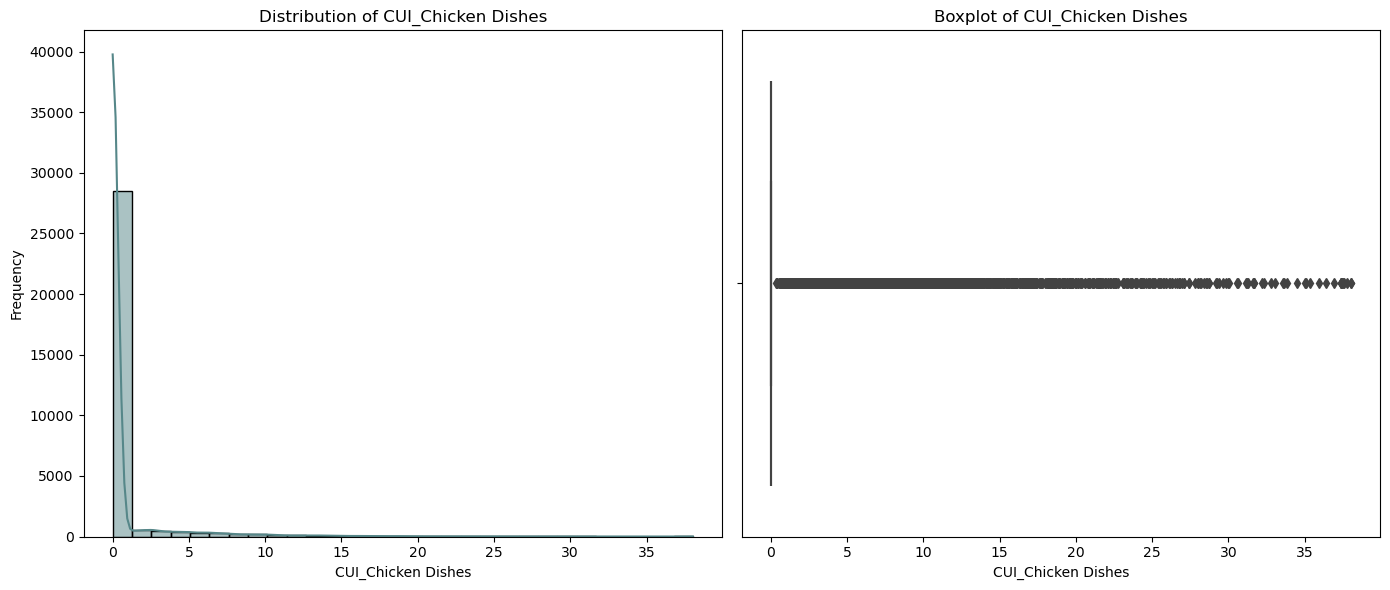

In [40]:
f.plot_distribution_and_boxplot(data_copy, 'CUI_Chicken Dishes')

9. *`CUI_Chinese`*

We first checked the distribution without the zero values in the respective feature.

In [41]:
cui_chinese_filter = data_copy[(data_copy['CUI_Chinese'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


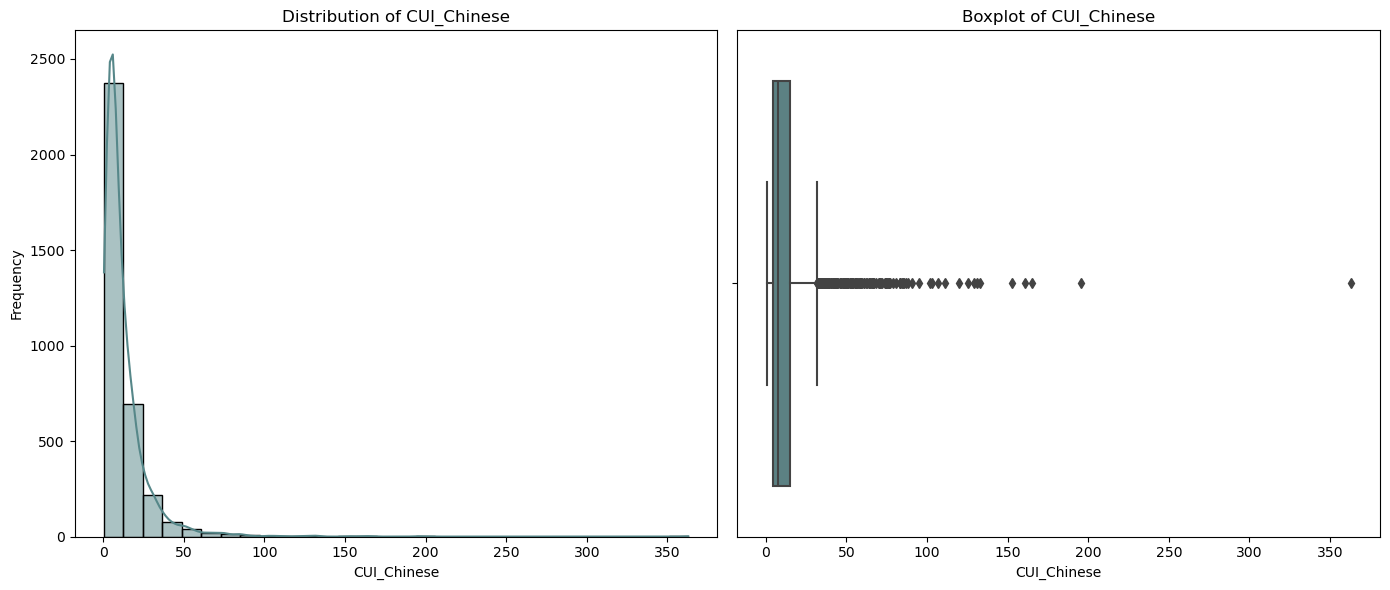

In [42]:
f.plot_distribution_and_boxplot(cui_chinese_filter, 'CUI_Chinese')

Based on the data distribution, we considered individuals with values higher than 90 as outliers, in this feature.

In [43]:
data_copy = data_copy[data_copy['CUI_Chinese'].lt(90)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


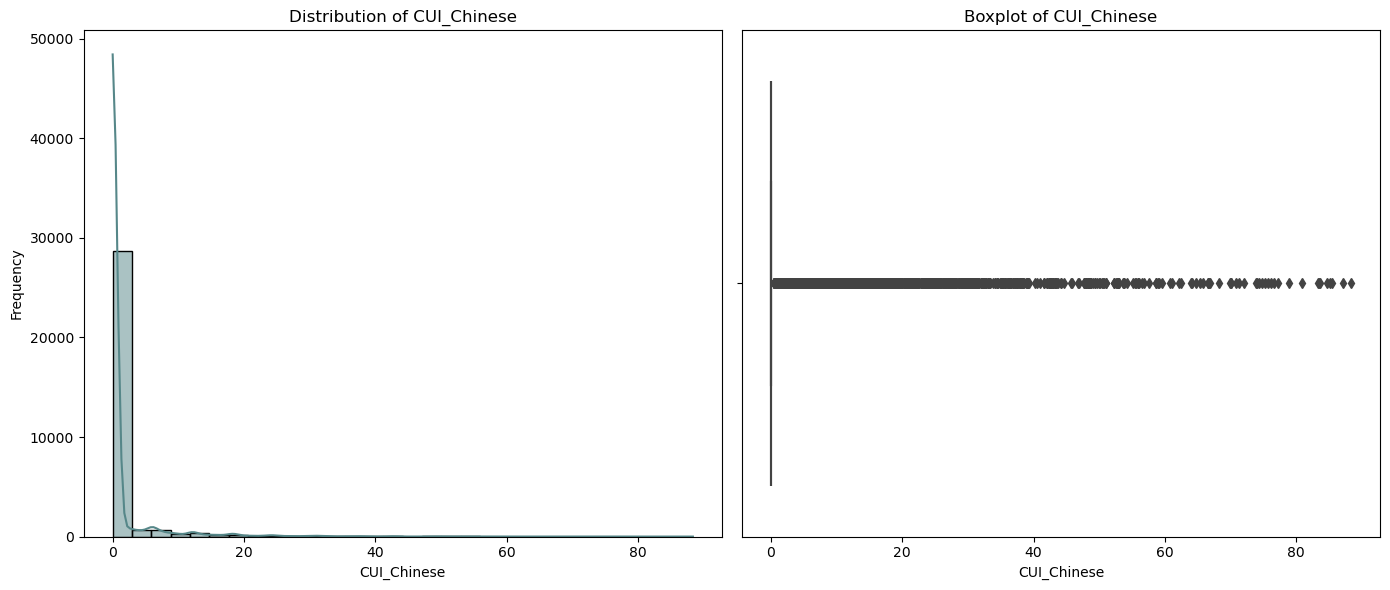

In [44]:
f.plot_distribution_and_boxplot(data_copy, 'CUI_Chinese')

10. *`CUI_Desserts`*

We first checked the distribution without the zero values in the respective feature.

In [45]:
cui_desserts_filter = data_copy[(data_copy['CUI_Desserts'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


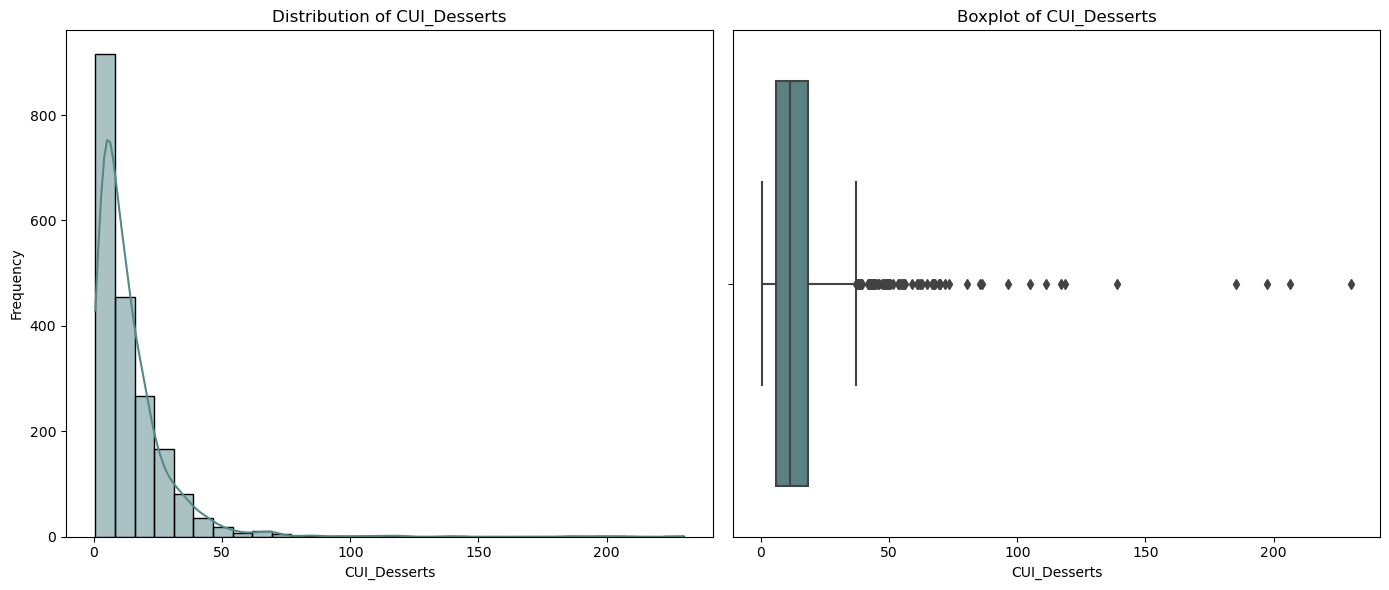

In [46]:
f.plot_distribution_and_boxplot(cui_desserts_filter, 'CUI_Desserts')

Based on the data distribution, we considered individuals with values higher than 80 as outliers, in this feature.

In [47]:
data_copy = data_copy[data_copy['CUI_Desserts'].lt(80)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


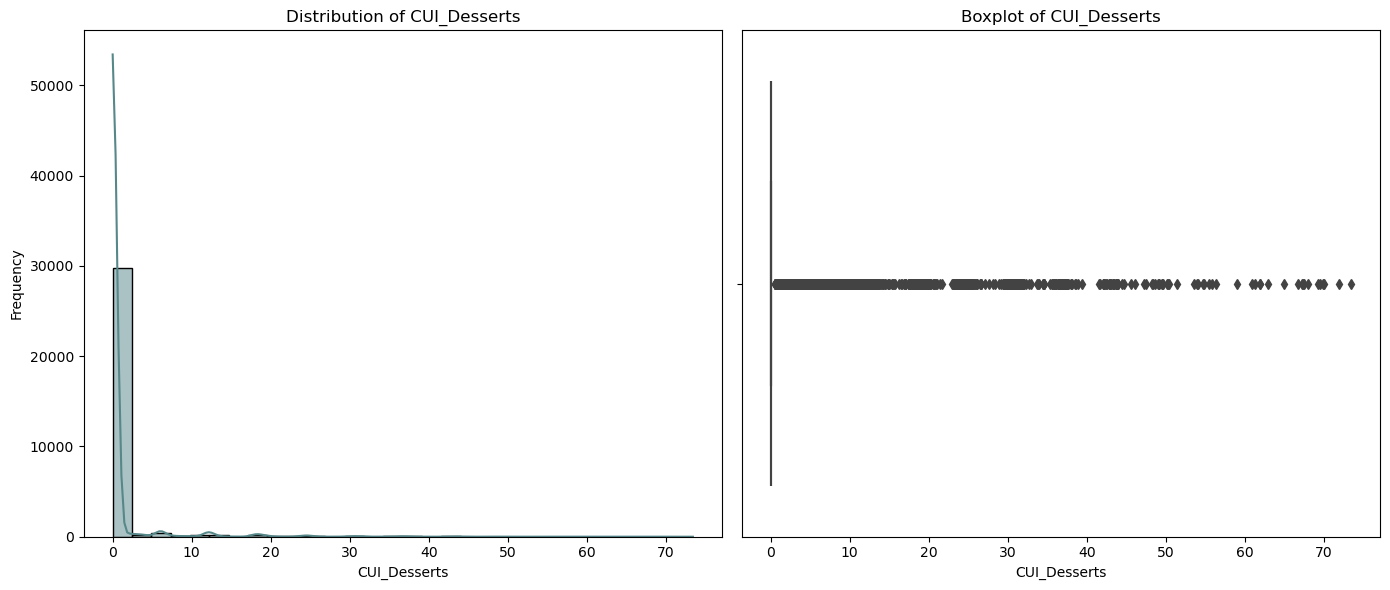

In [48]:
f.plot_distribution_and_boxplot(data_copy, 'CUI_Desserts')

11. *`CUI_Healthy`*

We first checked the distribution without the zero values in the respective feature.

In [49]:
cui_healthy_filter = data_copy[(data_copy['CUI_Healthy'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


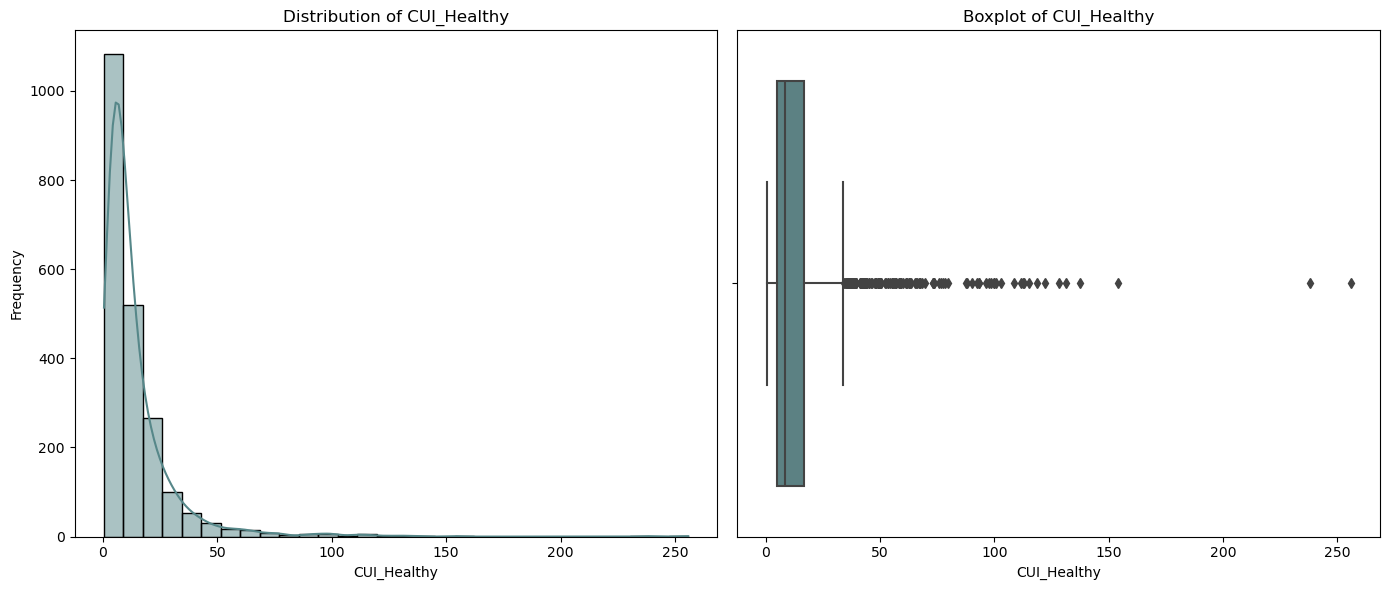

In [50]:
f.plot_distribution_and_boxplot(cui_healthy_filter, 'CUI_Healthy')

Based on the data distribution, we considered individuals with values higher than 69 as outliers, in this feature.

In [51]:
data_copy = data_copy[data_copy['CUI_Healthy'].lt(69)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


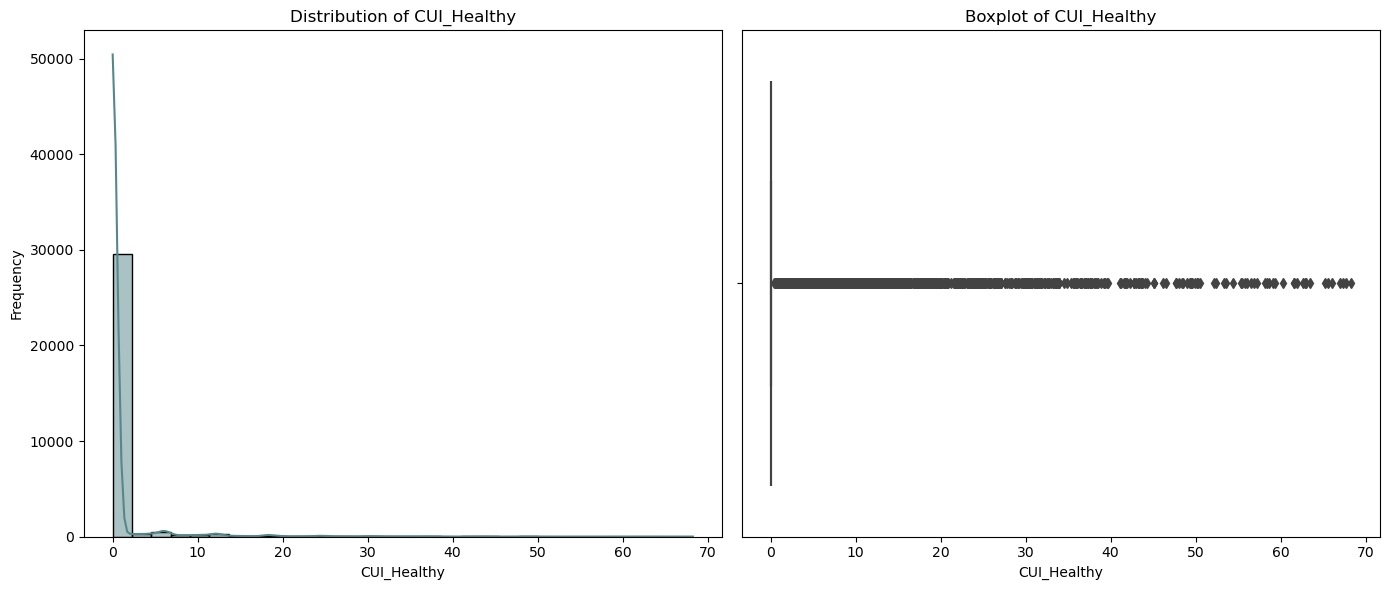

In [52]:
f.plot_distribution_and_boxplot(data_copy, 'CUI_Healthy')

12. *`CUI_Indian`*

We first checked the distribution without the zero values in the respective feature.

In [53]:
cui_indian_filter = data_copy[(data_copy['CUI_Indian'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


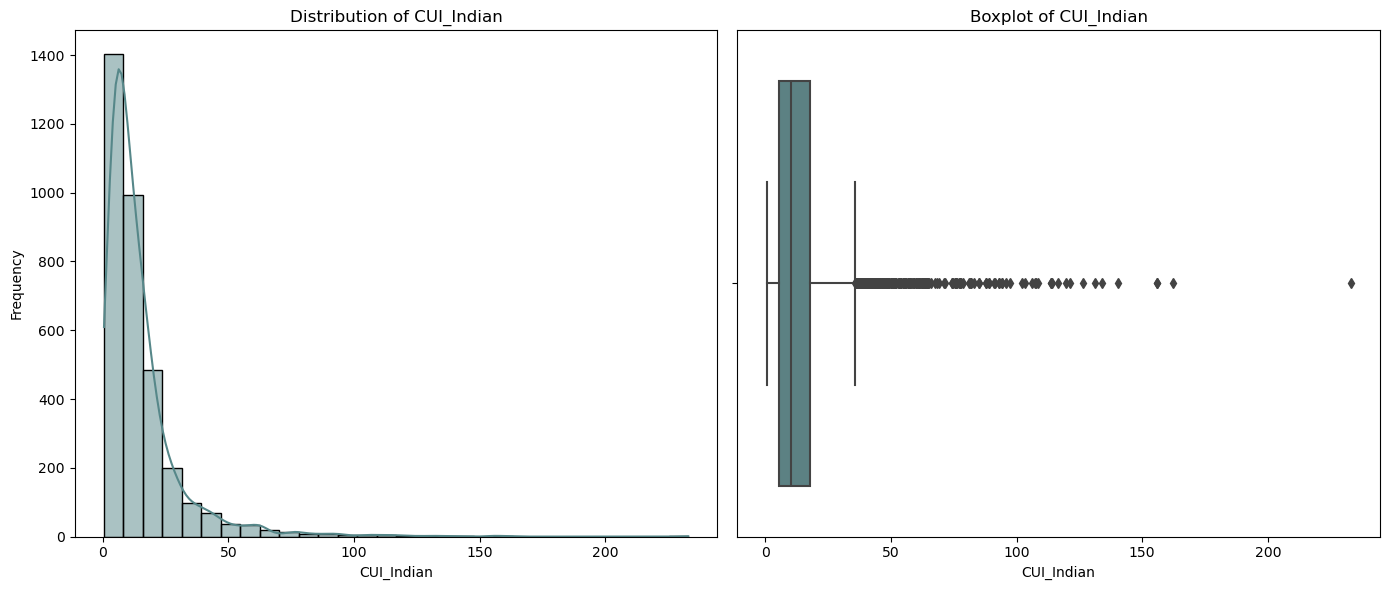

In [54]:
f.plot_distribution_and_boxplot(cui_indian_filter, 'CUI_Indian')

Based on the data distribution, we considered individuals with values higher than 100 as outliers, in this feature.

In [55]:
data_copy = data_copy[data_copy['CUI_Indian'].le(100)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


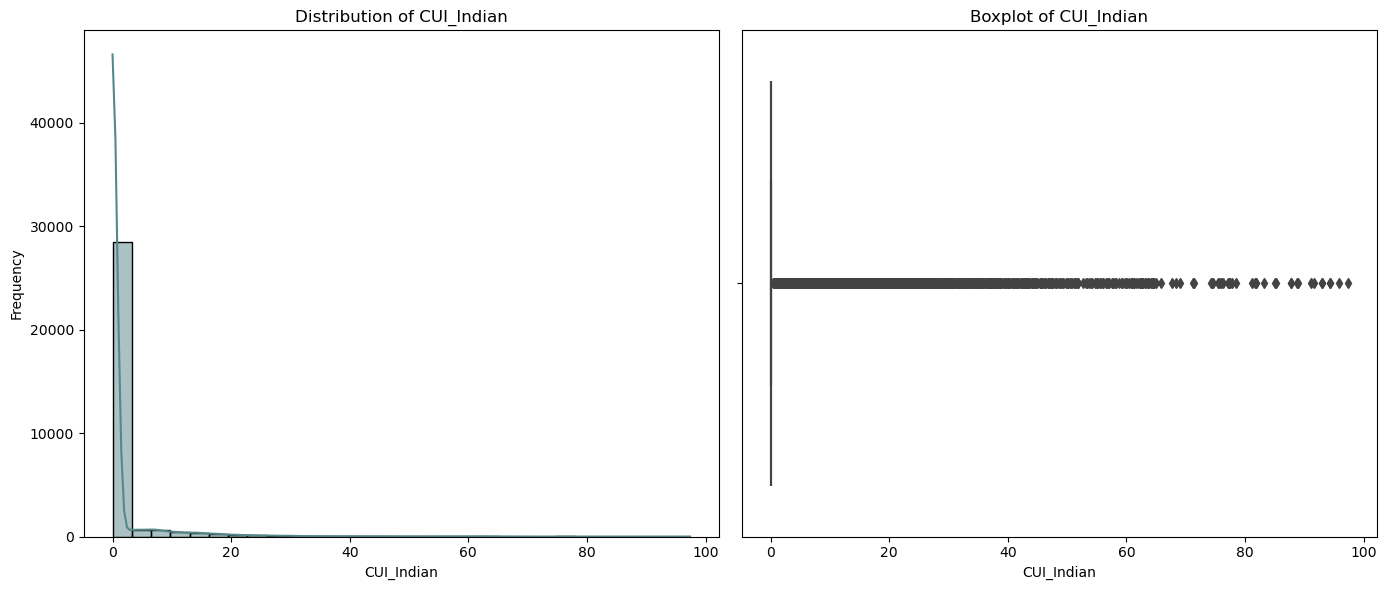

In [56]:
f.plot_distribution_and_boxplot(data_copy, 'CUI_Indian')

13. *`CUI_Italian`*

We first checked the distribution without the zero values in the respective feature.

In [57]:
cui_italian_filter = data_copy[(data_copy['CUI_Italian'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


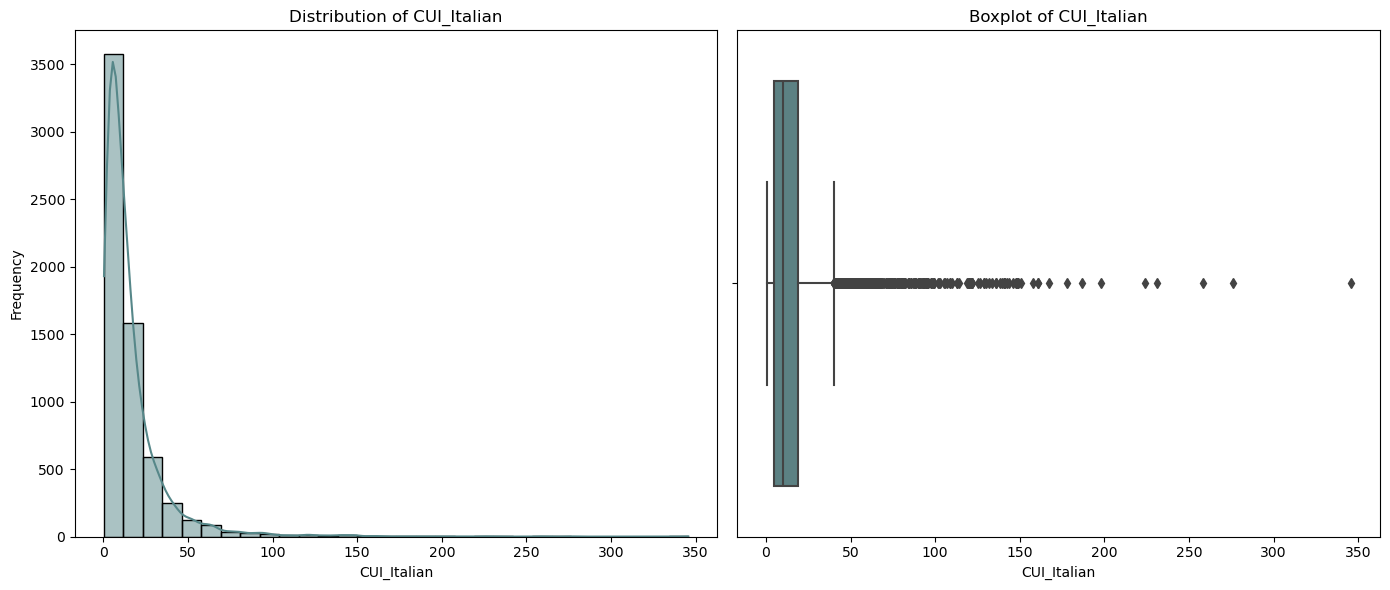

In [58]:
f.plot_distribution_and_boxplot(cui_italian_filter, 'CUI_Italian')

Based on the data distribution, we considered individuals with values higher than 155 as outliers, in this feature.

In [59]:
data_copy = data_copy[data_copy['CUI_Italian'].lt(155)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


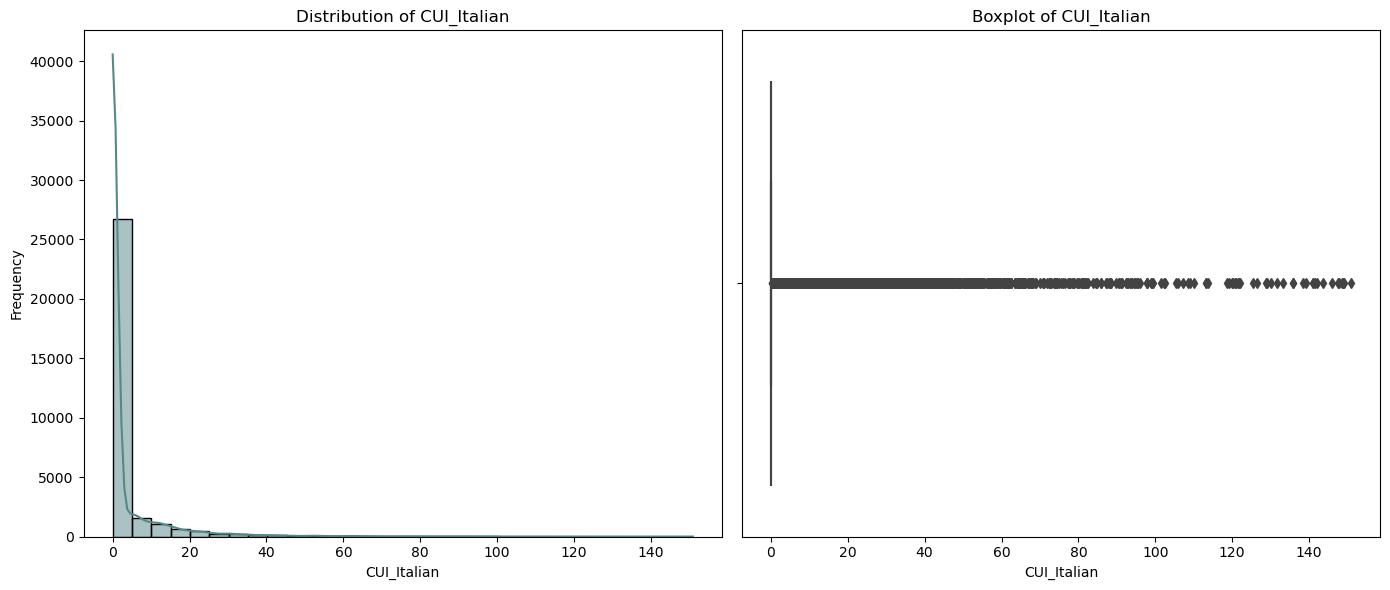

In [60]:
f.plot_distribution_and_boxplot(data_copy, 'CUI_Italian')

14. *`CUI_Japanese`*

We first checked the distribution without the zero values in the respective feature.

In [61]:
cui_japanese_filter = data_copy[(data_copy['CUI_Japanese'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


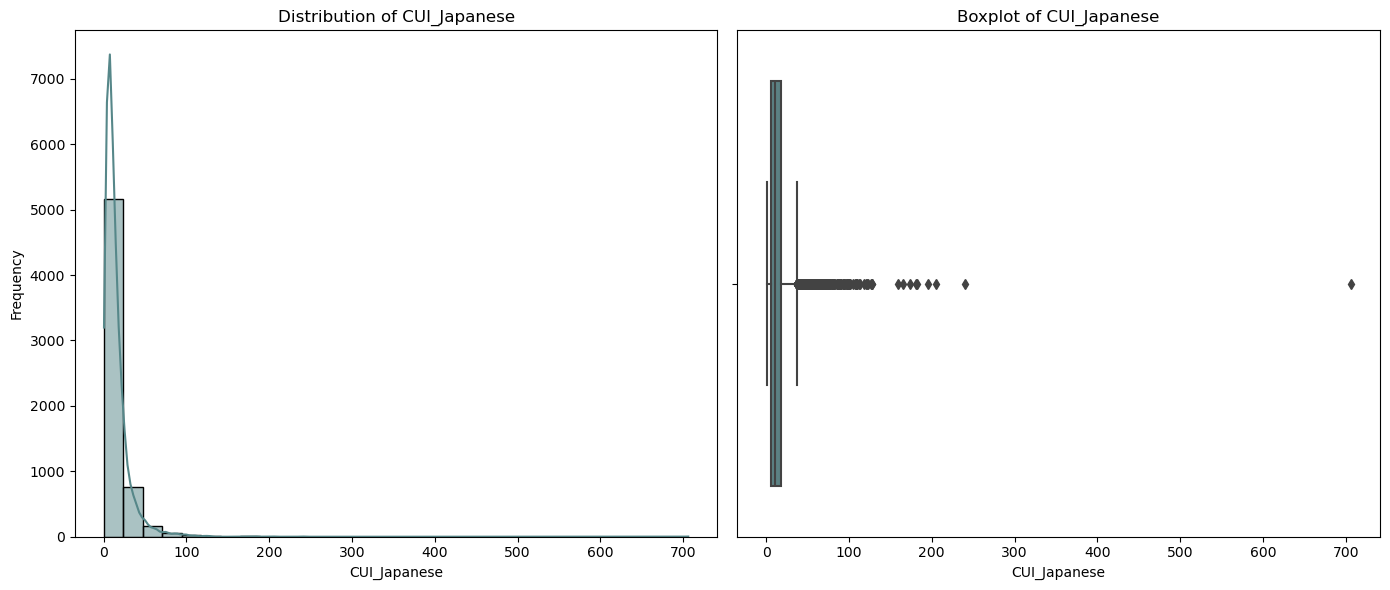

In [62]:
f.plot_distribution_and_boxplot(cui_japanese_filter, 'CUI_Japanese')

Based on the data distribution, we considered individuals with values higher than 155 as outliers, in this feature.

In [63]:
data_copy = data_copy[data_copy['CUI_Japanese'].lt(115)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


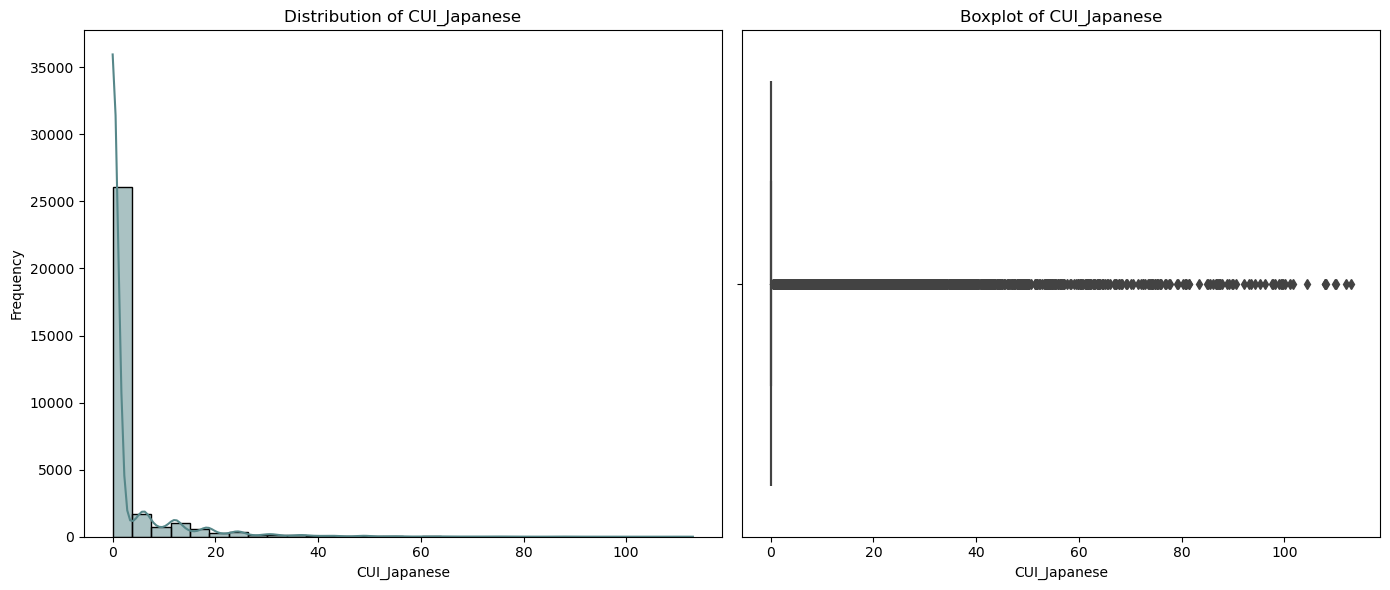

In [64]:
f.plot_distribution_and_boxplot(data_copy, 'CUI_Japanese')

15. *`CUI_Noodle Dishes`*

We first checked the distribution without the zero values in the respective feature.

In [65]:
cui_noodle_filter = data_copy[(data_copy['CUI_Noodle Dishes'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


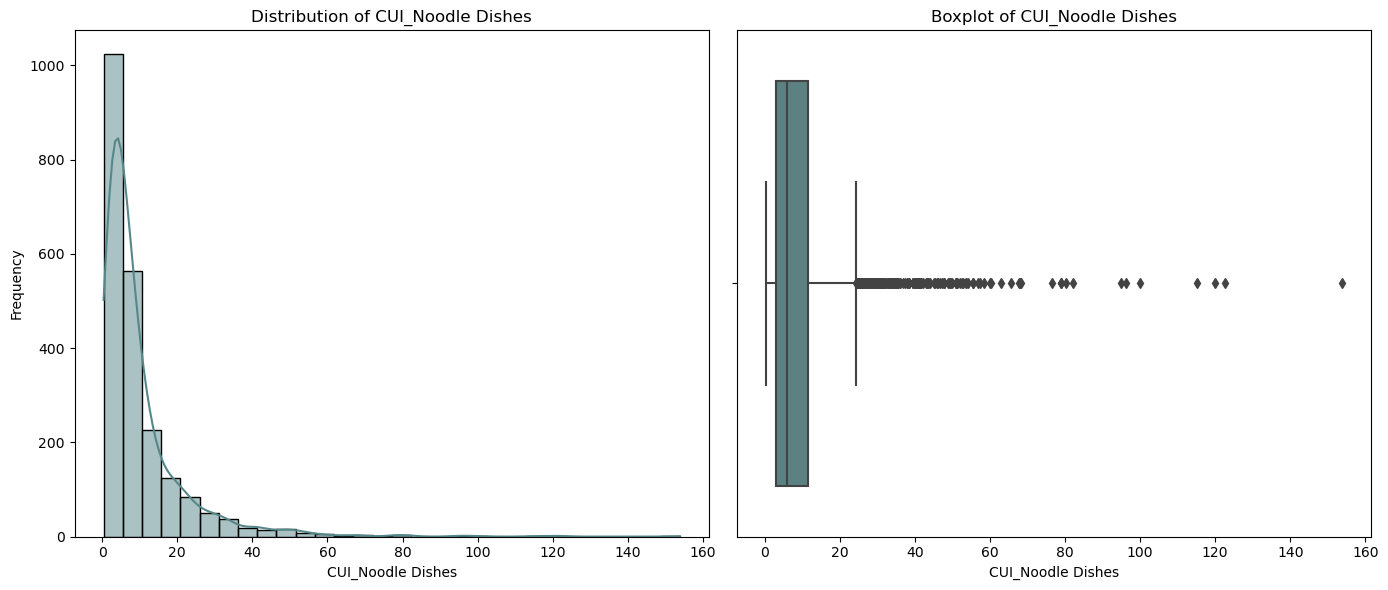

In [66]:
f.plot_distribution_and_boxplot(cui_noodle_filter, 'CUI_Noodle Dishes')

Based on the data distribution, we considered individuals with values higher than 60 as outliers, in this feature.

In [67]:
data_copy = data_copy[data_copy['CUI_Noodle Dishes'].le(60)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


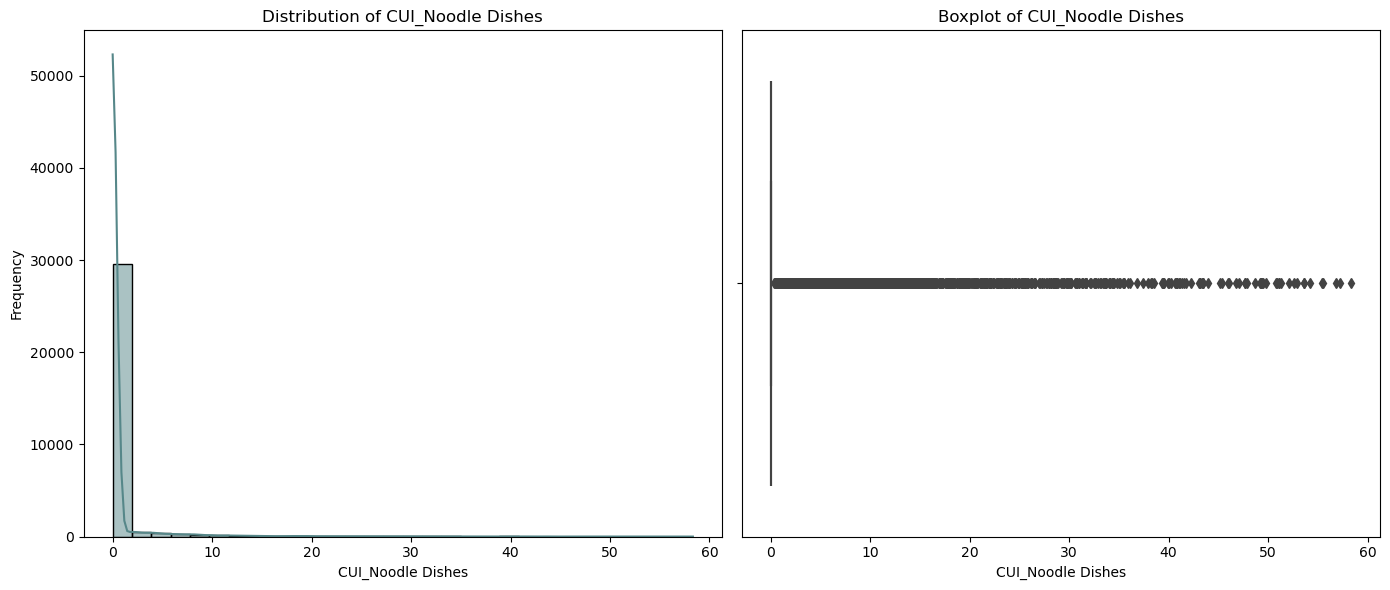

In [68]:
f.plot_distribution_and_boxplot(data_copy, 'CUI_Noodle Dishes')

16. *`CUI_OTHER`*

We first checked the distribution without the zero values in the respective feature.

In [69]:
cui_other_filter = data_copy[(data_copy['CUI_OTHER'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


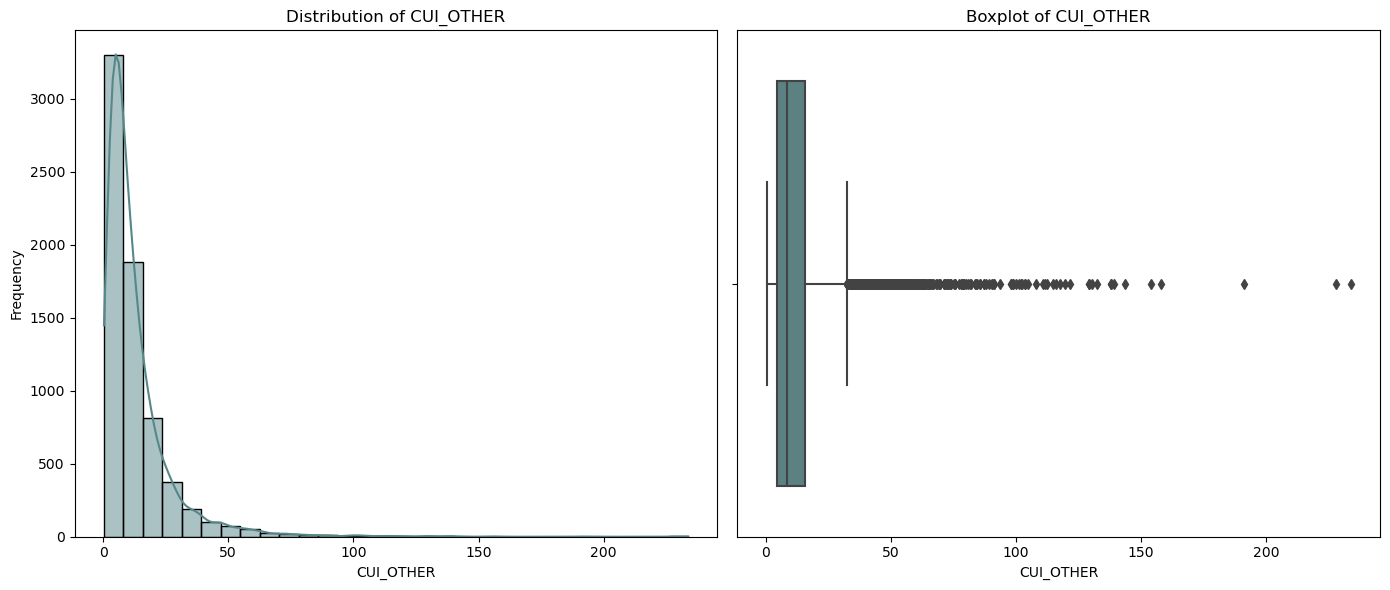

In [70]:
f.plot_distribution_and_boxplot(cui_other_filter, 'CUI_OTHER')

Based on the data distribution, we considered individuals with values higher than 129 as outliers, in this feature.

In [71]:
data_copy = data_copy[data_copy['CUI_OTHER'].lt(129)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


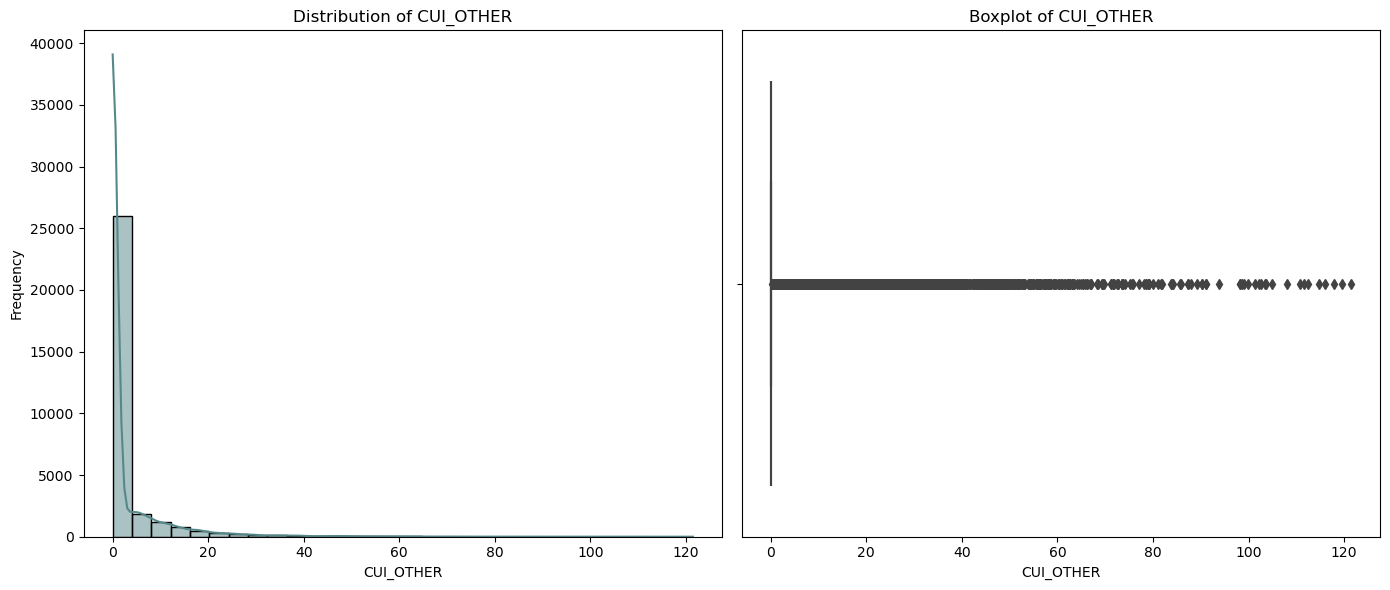

In [72]:
f.plot_distribution_and_boxplot(data_copy, 'CUI_OTHER')

17. *`CUI_Street Food / Snacks`*

We first checked the distribution without the zero values in the respective feature.

In [73]:
cui_snacks_filter = data_copy[(data_copy['CUI_Street Food / Snacks'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


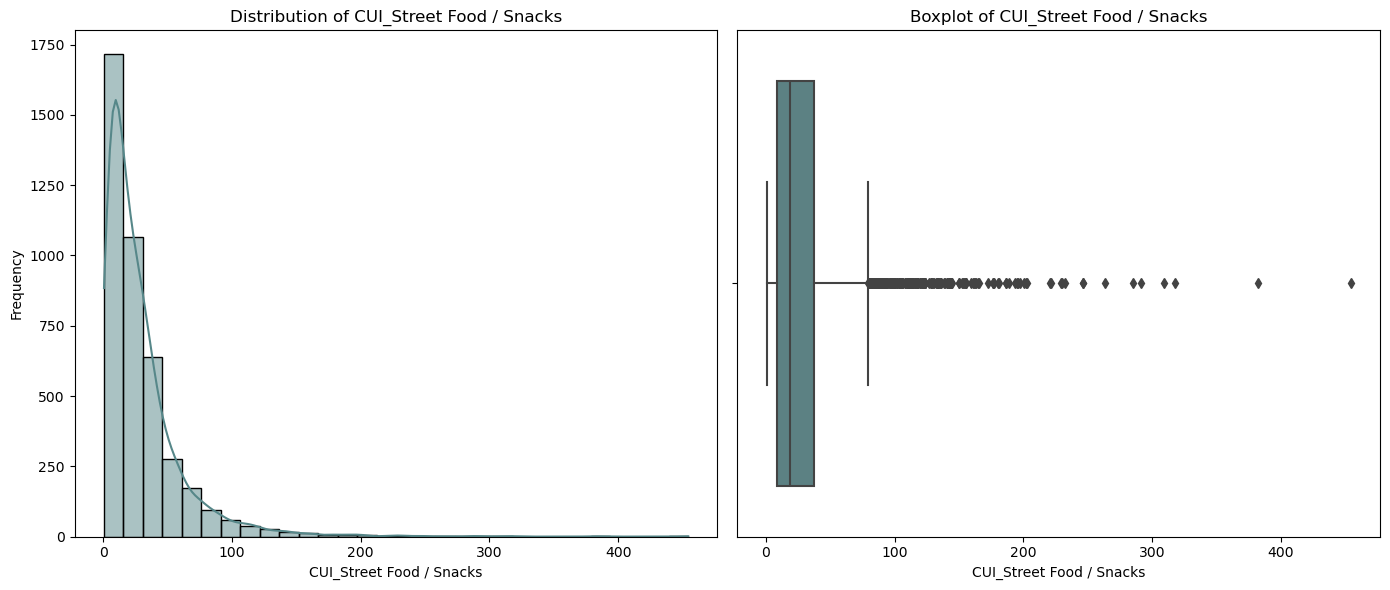

In [74]:
f.plot_distribution_and_boxplot(cui_snacks_filter, 'CUI_Street Food / Snacks')

Based on the data distribution, we considered individuals with values higher than 215 as outliers, in this feature.

In [75]:
data_copy = data_copy[data_copy['CUI_Street Food / Snacks'].lt(215)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


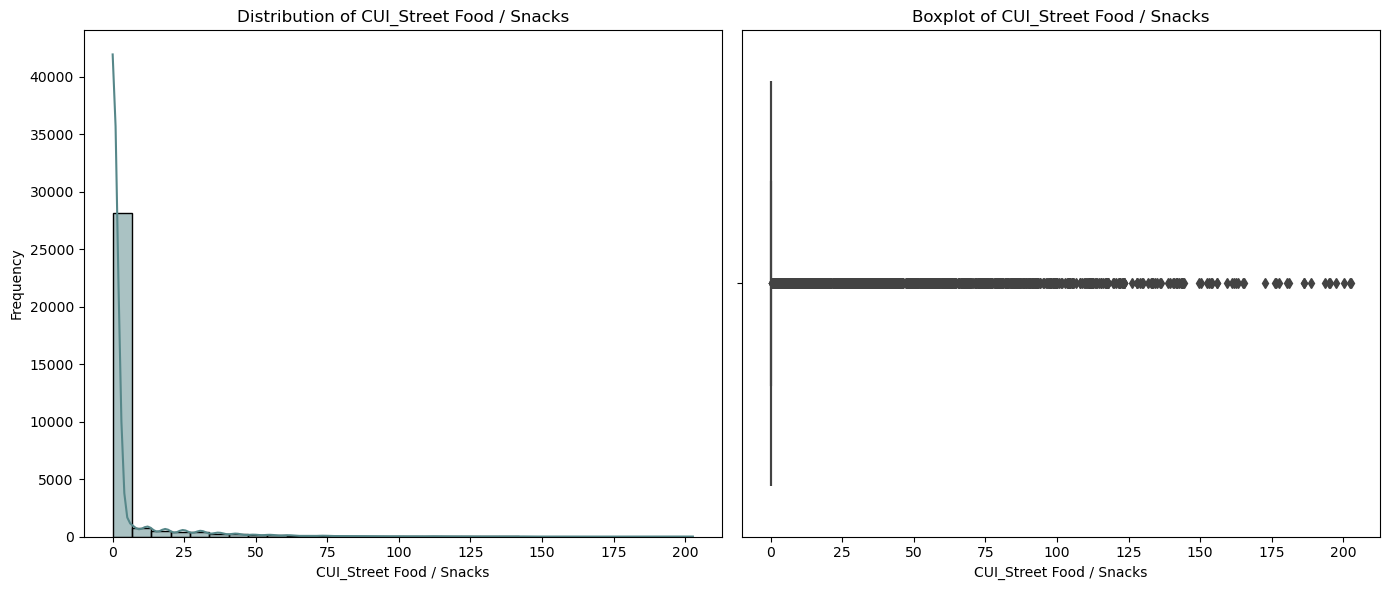

In [76]:
f.plot_distribution_and_boxplot(data_copy, 'CUI_Street Food / Snacks')

18. *`CUI_Thai`*

We first checked the distribution without the zero values in the respective feature.

In [77]:
cui_thai_filter = data_copy[(data_copy['CUI_Thai'] != 0)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


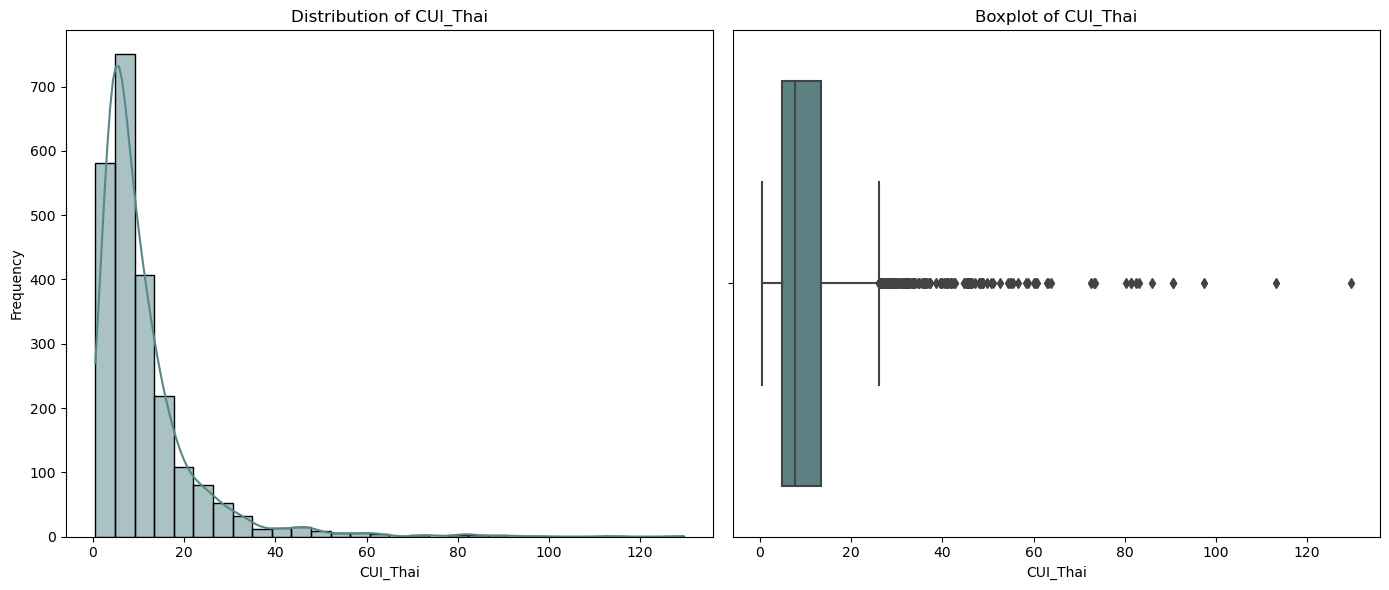

In [78]:
f.plot_distribution_and_boxplot(cui_thai_filter, 'CUI_Thai')

Based on the data distribution, we considered individuals with values higher than 65 as outliers, in this feature.

In [79]:
data_copy = data_copy[data_copy['CUI_Thai'].lt(65)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


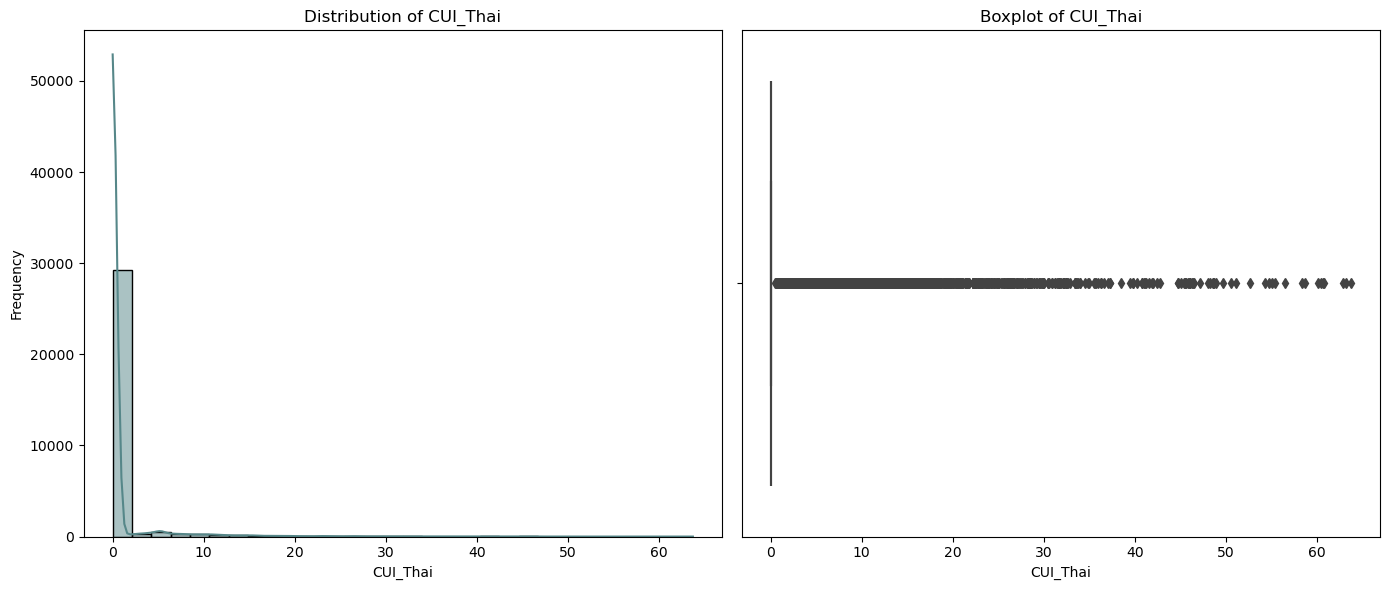

In [80]:
f.plot_distribution_and_boxplot(data_copy, 'CUI_Thai')

19. *`DOW features`*

For these variables, most of the extreme values were removed during the removal of extreme values in other features. However, some extreme values still remain, so we will remove them as well. We first checked the distribution without the zero values in the respective feature.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


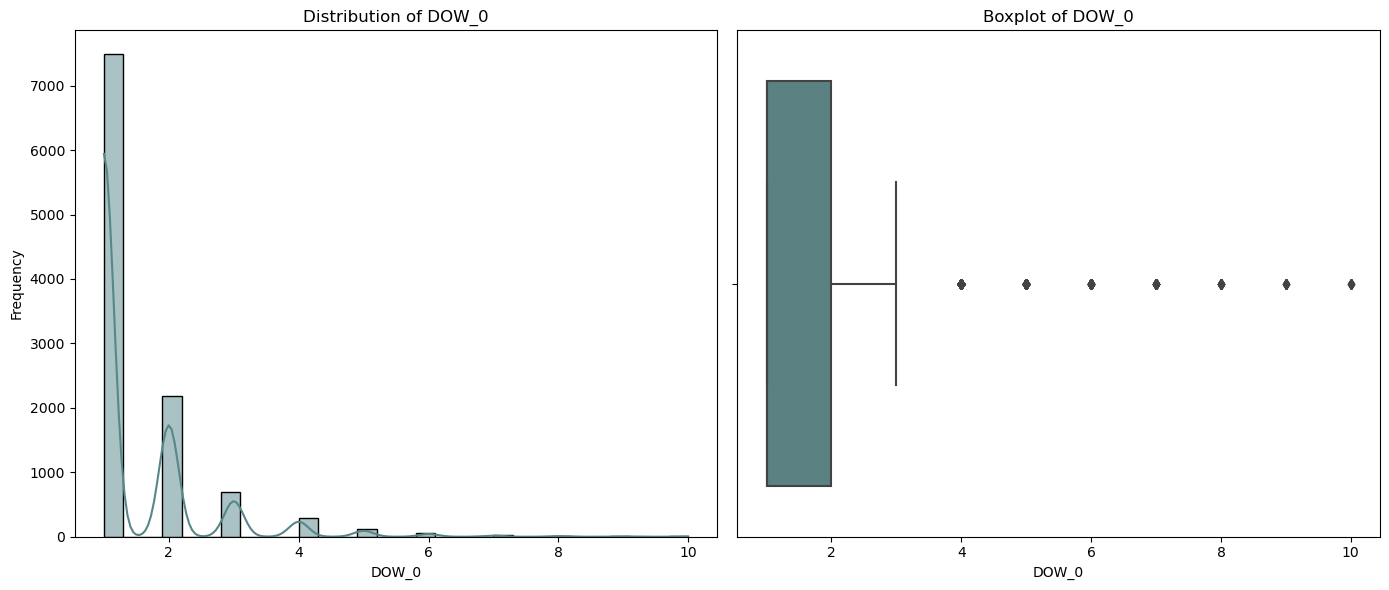

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


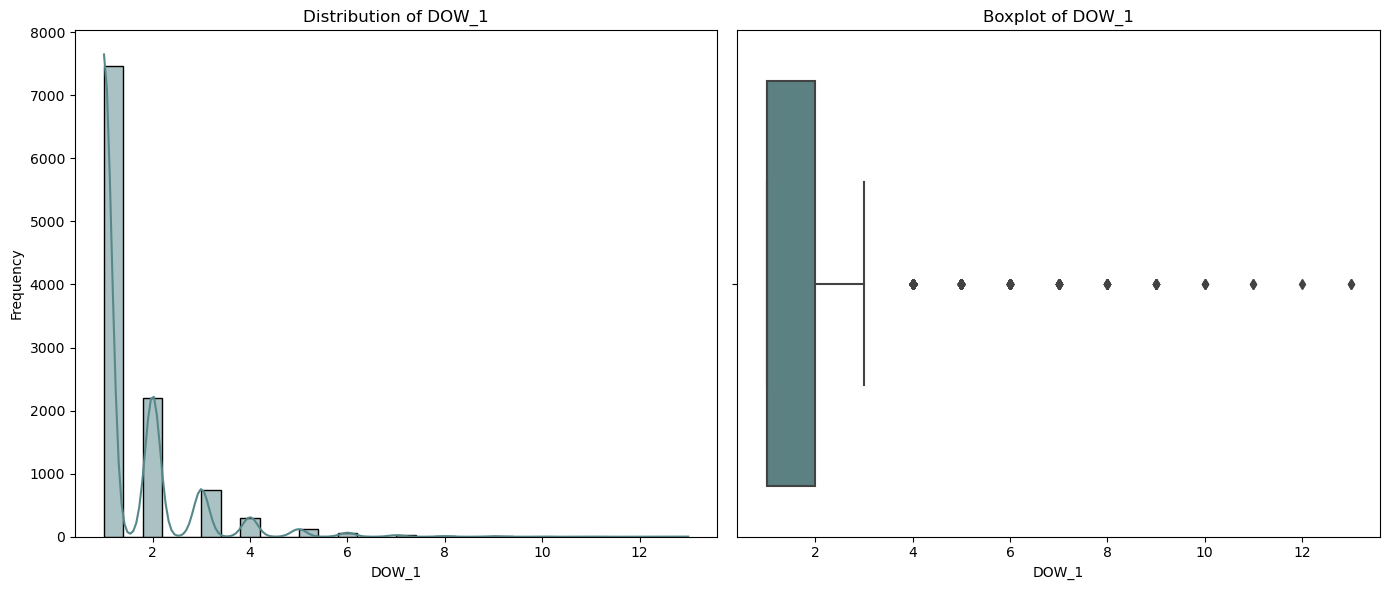

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


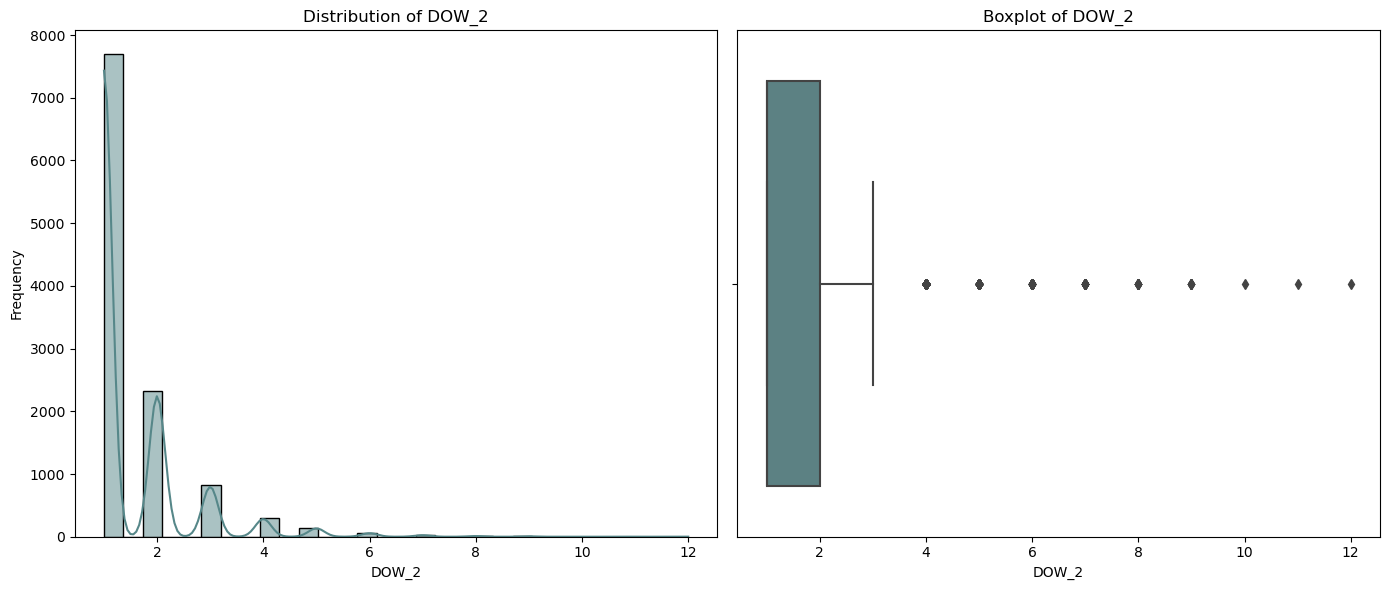

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


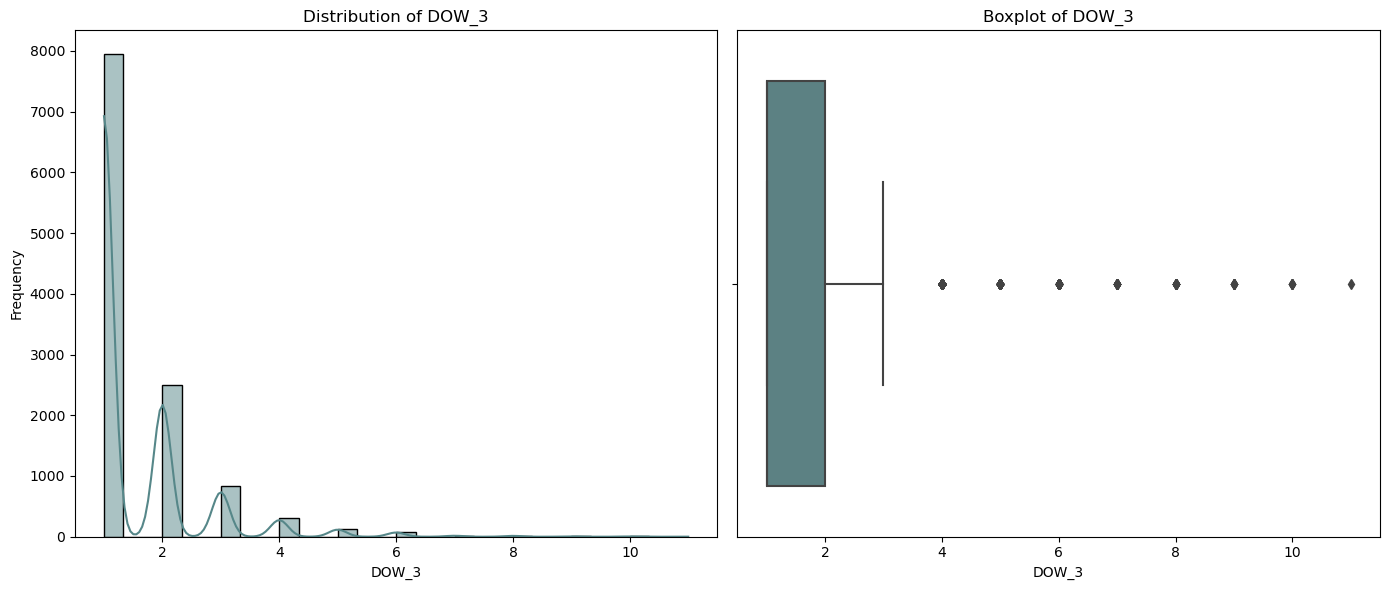

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


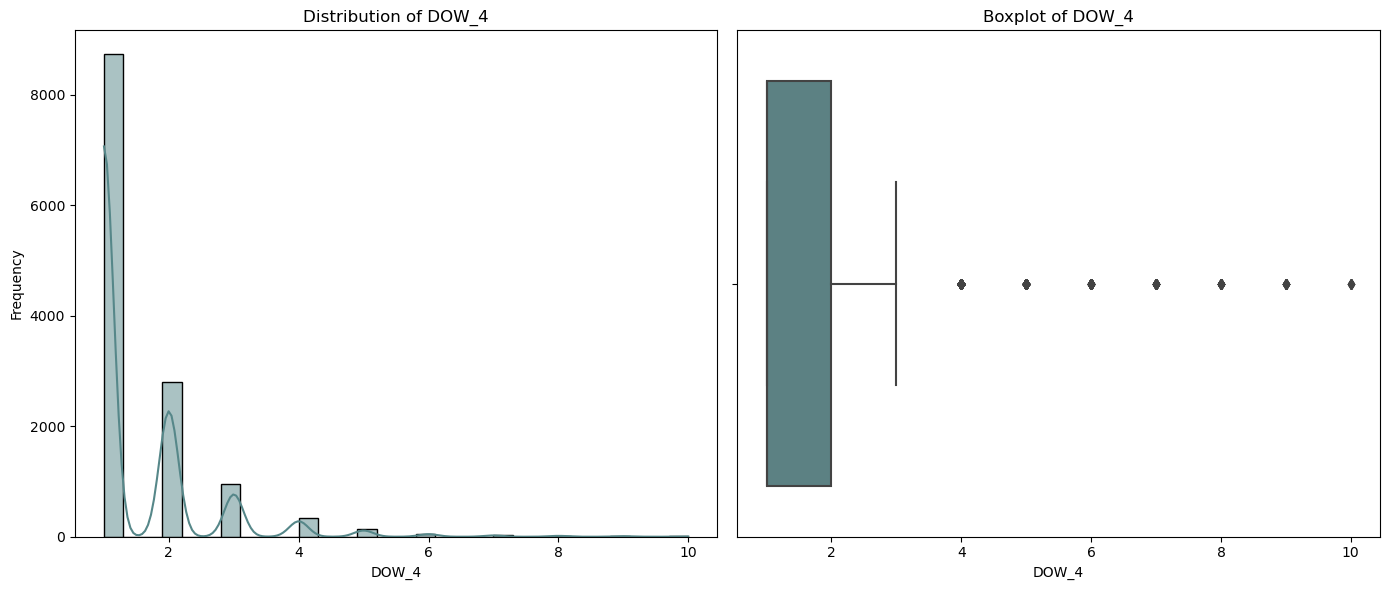

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


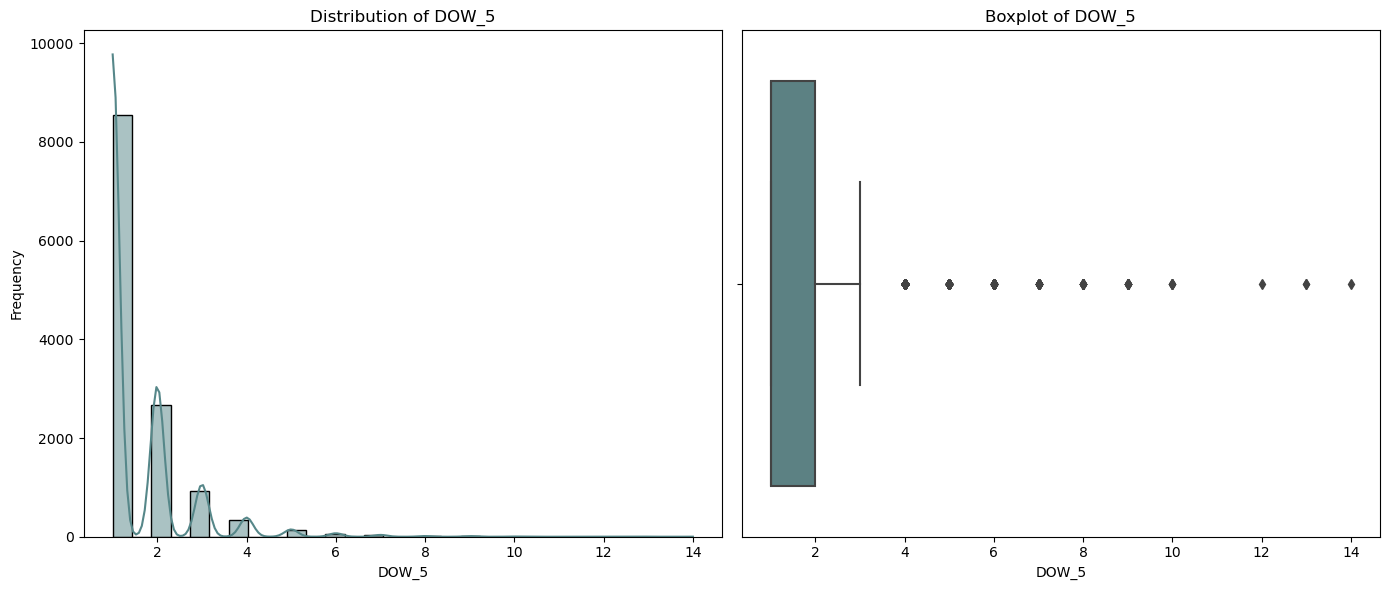

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


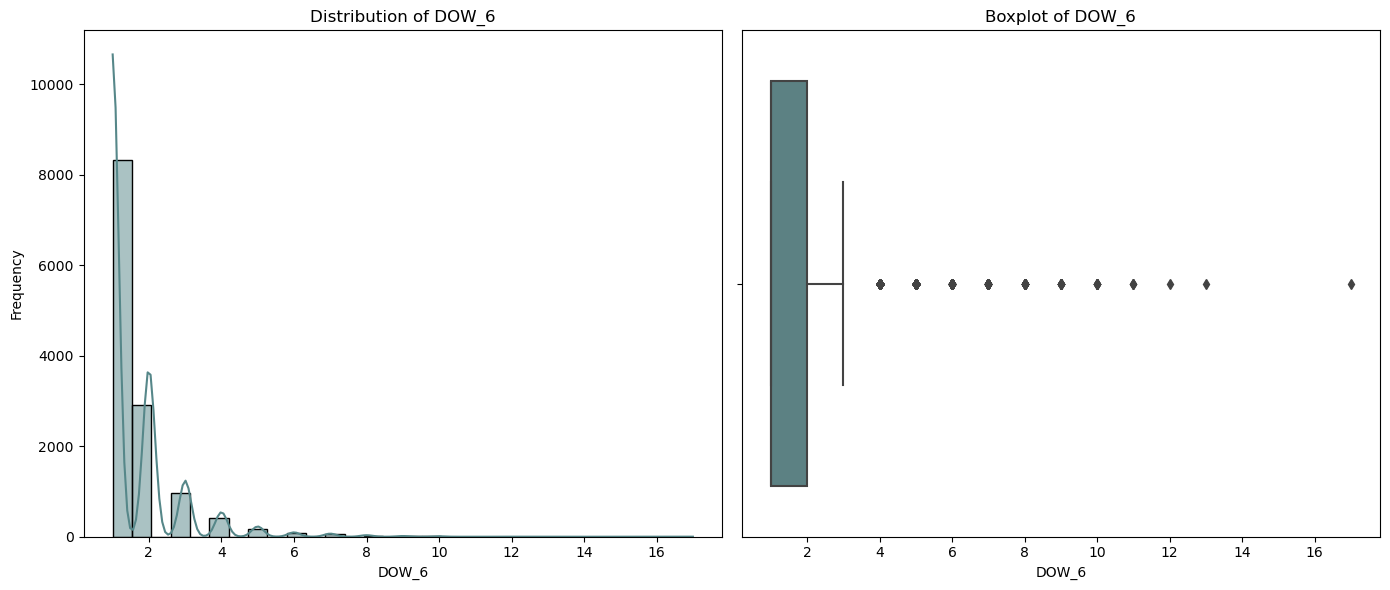

In [81]:
dow0_filter = data_copy[(data_copy['DOW_0'] != 0)]
dow1_filter = data_copy[(data_copy['DOW_1'] != 0)]
dow2_filter = data_copy[(data_copy['DOW_2'] != 0)]
dow3_filter = data_copy[(data_copy['DOW_3'] != 0)]
dow4_filter = data_copy[(data_copy['DOW_4'] != 0)]
dow5_filter = data_copy[(data_copy['DOW_5'] != 0)]
dow6_filter = data_copy[(data_copy['DOW_6'] != 0)]

f.plot_distribution_and_boxplot(dow0_filter, 'DOW_0')
f.plot_distribution_and_boxplot(dow1_filter, 'DOW_1')
f.plot_distribution_and_boxplot(dow2_filter, 'DOW_2')
f.plot_distribution_and_boxplot(dow3_filter, 'DOW_3')
f.plot_distribution_and_boxplot(dow4_filter, 'DOW_4')
f.plot_distribution_and_boxplot(dow5_filter, 'DOW_5')
f.plot_distribution_and_boxplot(dow6_filter, 'DOW_6')

Based on the data distribution, we only identified outliers in the `DOW_6` feature. In this way, only the individual with number of orders placed on Saturday higher than 15 was considered an outlier.

In [82]:
data_copy = data_copy[data_copy['DOW_6'].lt(15)]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


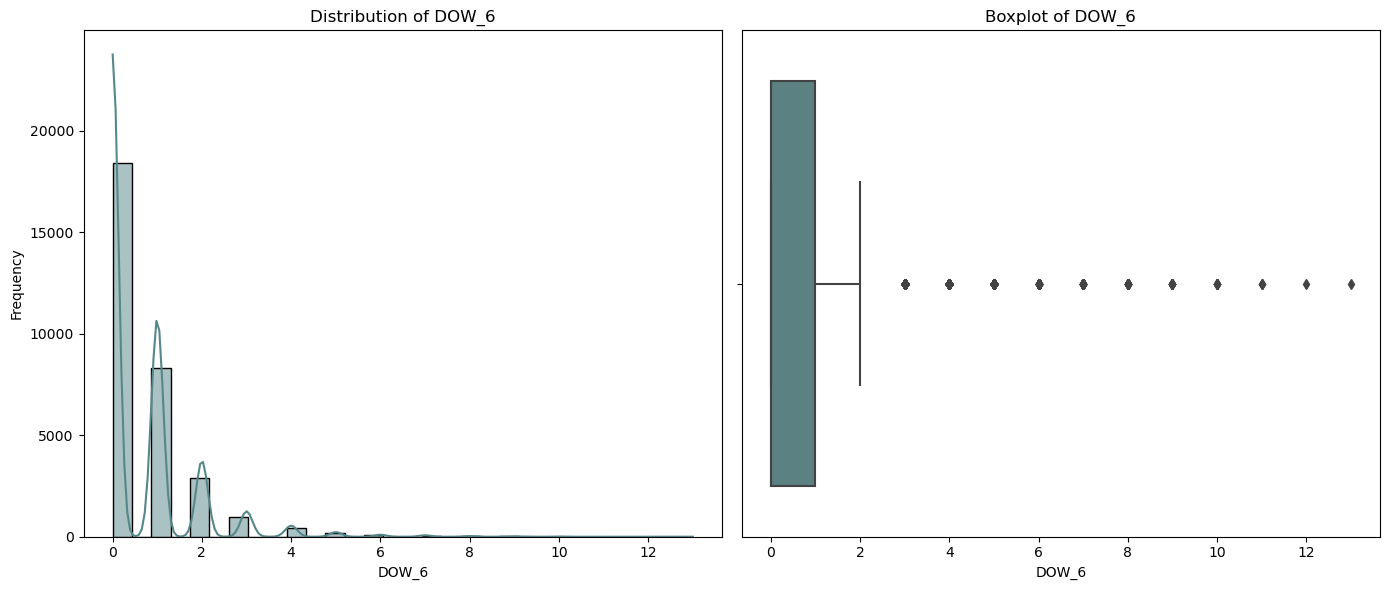

In [83]:
f.plot_distribution_and_boxplot(data_copy, 'DOW_6')

20. *`Hours of the day features`*

For these features, the presence of 0 values had no impact on the data distribution. Therefore, we proceed to analyze the data distribution.

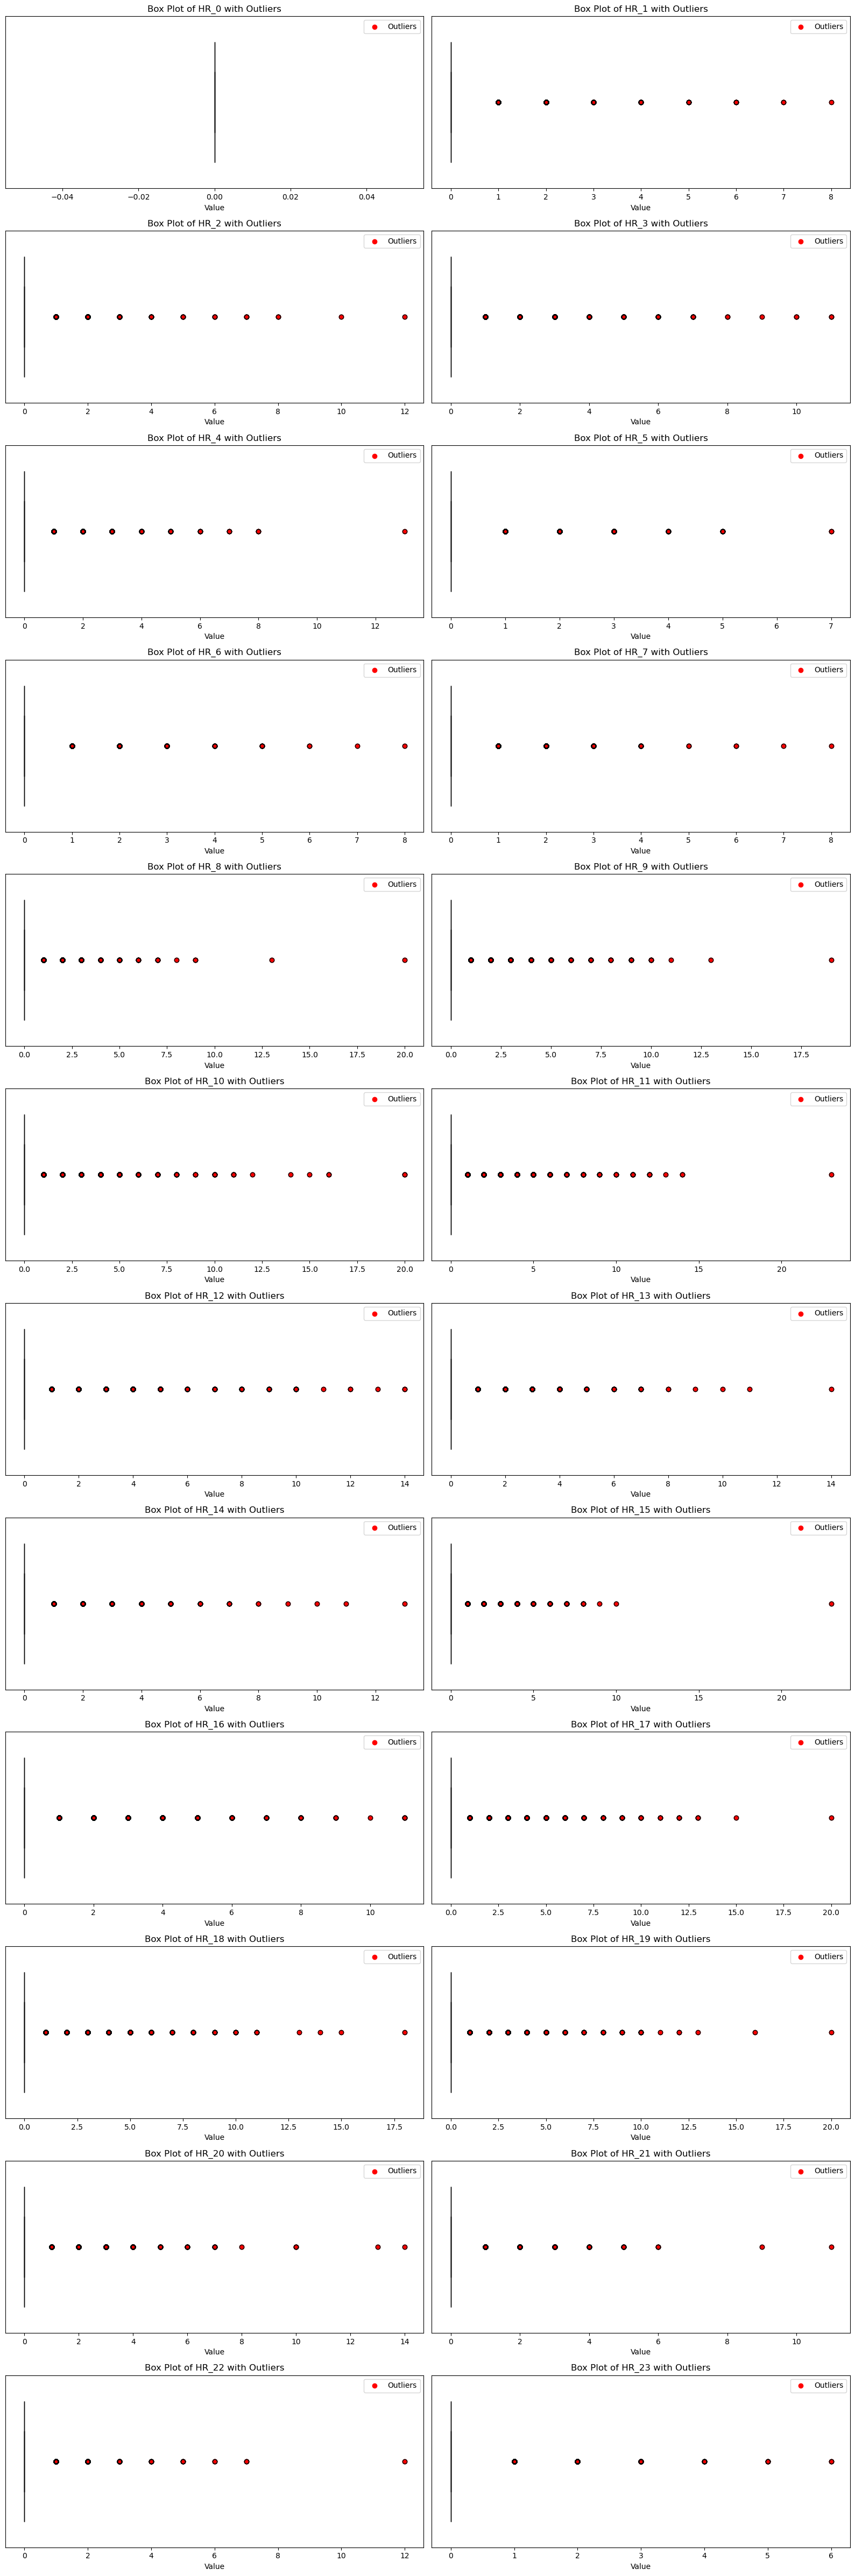

In [84]:
hours = ['HR_0', 'HR_1', 'HR_2', 'HR_3',
       'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11',
       'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18',
       'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23']

f.plot_multiple_boxes_with_outliers1(data_copy, hours)

The boxplots revealed outliers in most of the features. As a result, we proceed with their treatment based on the dispersion of the data points.

In [85]:
data_copy = data_copy[data_copy['HR_2'].lt(10)]
data_copy = data_copy[data_copy['HR_4'].lt(10)]
data_copy = data_copy[data_copy['HR_5'].lt(6)]
data_copy = data_copy[data_copy['HR_8'].lt(10)]
data_copy = data_copy[data_copy['HR_9'].le(12)]
data_copy = data_copy[data_copy['HR_10'].le(17)]
data_copy = data_copy[data_copy['HR_11'].le(15)]
data_copy = data_copy[data_copy['HR_12'].le(12)]
data_copy = data_copy[data_copy['HR_13'].lt(12)]
data_copy = data_copy[data_copy['HR_14'].lt(10)]
data_copy = data_copy[data_copy['HR_15'].le(15)]
data_copy = data_copy[data_copy['HR_17'].lt(15)]
data_copy = data_copy[data_copy['HR_18'].lt(17)]
data_copy = data_copy[data_copy['HR_19'].lt(15)]
data_copy = data_copy[data_copy['HR_20'].lt(9)]
data_copy = data_copy[data_copy['HR_21'].lt(8)]
data_copy = data_copy[data_copy['HR_22'].lt(8)]

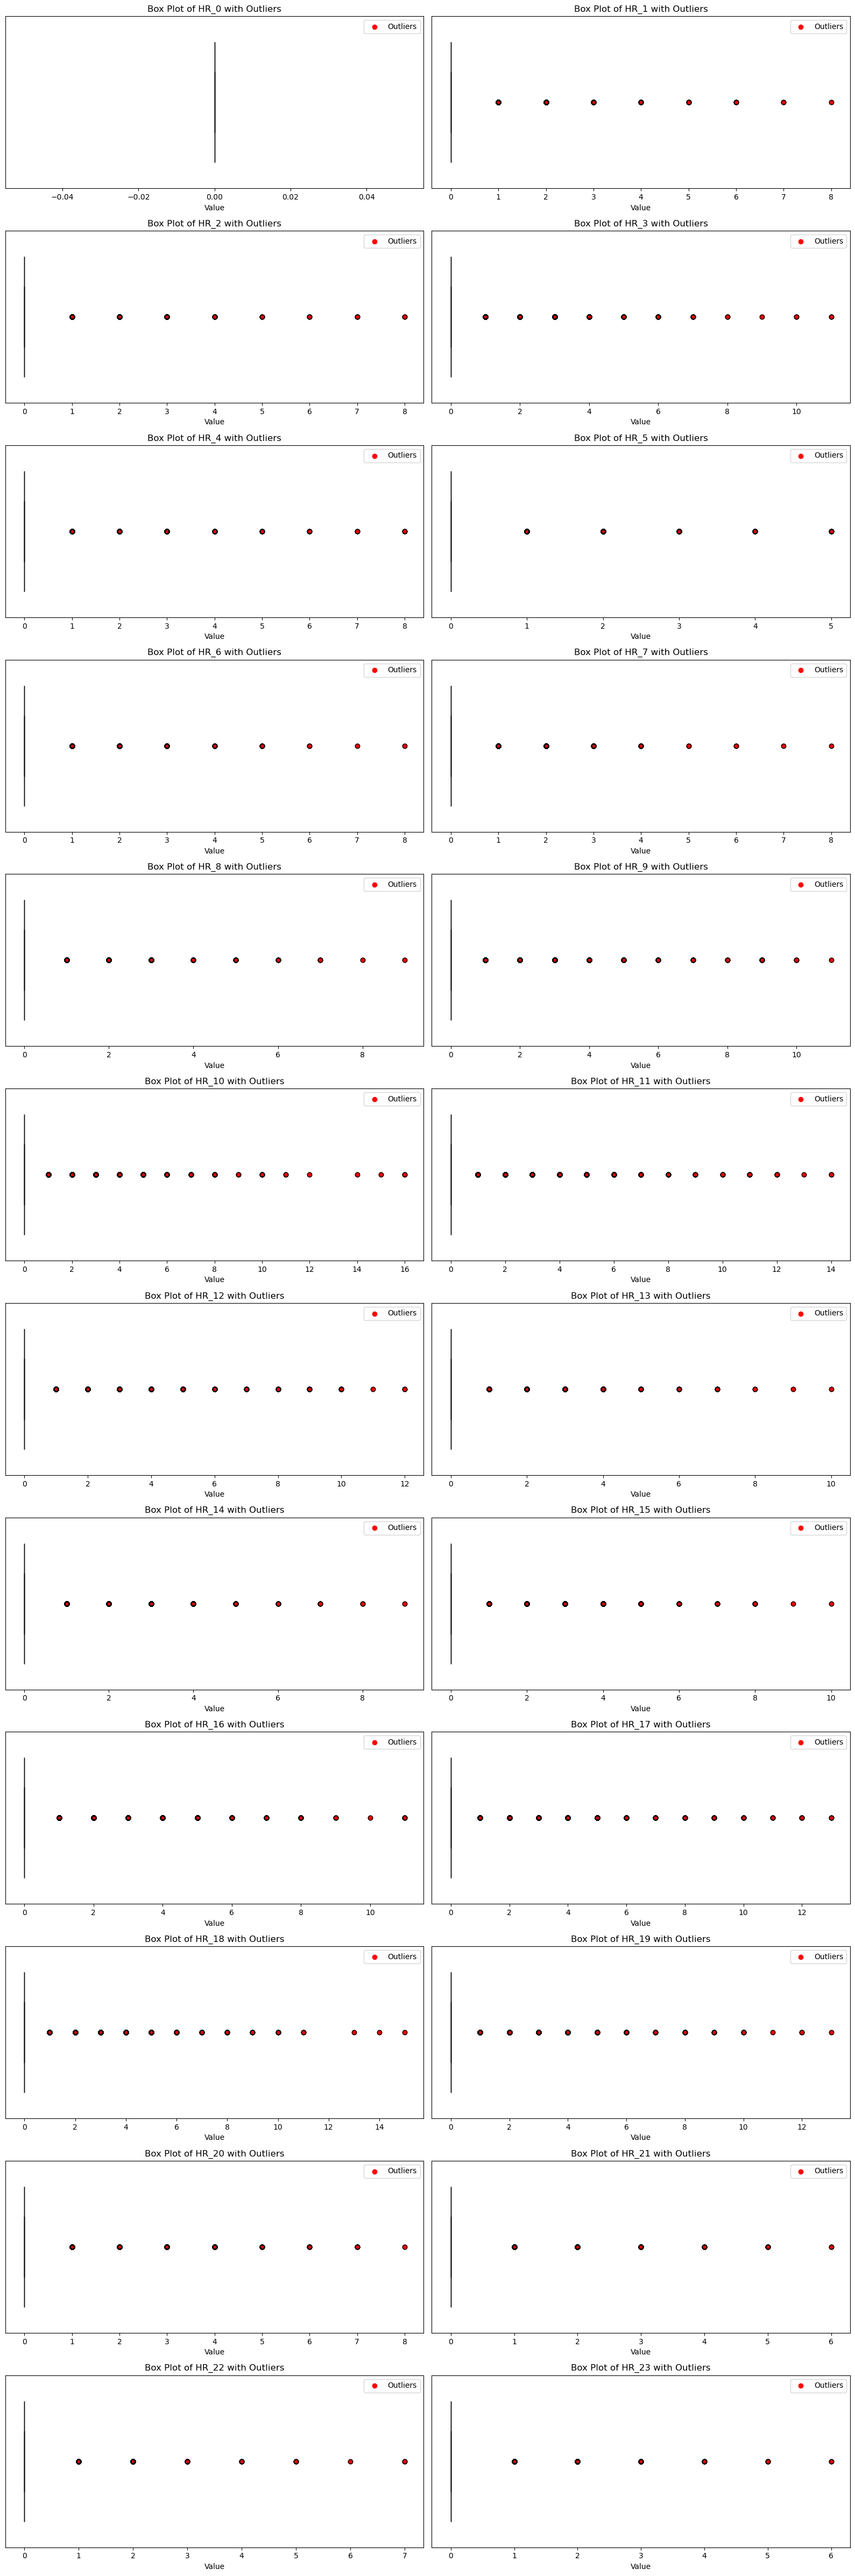

In [86]:
f.plot_multiple_boxes_with_outliers1(data_copy, hours)

21. *`Columns from feature engineering`*

In the previous notebook, new features were created. Thus, we will examine them using boxplots to identify any potential extreme values.

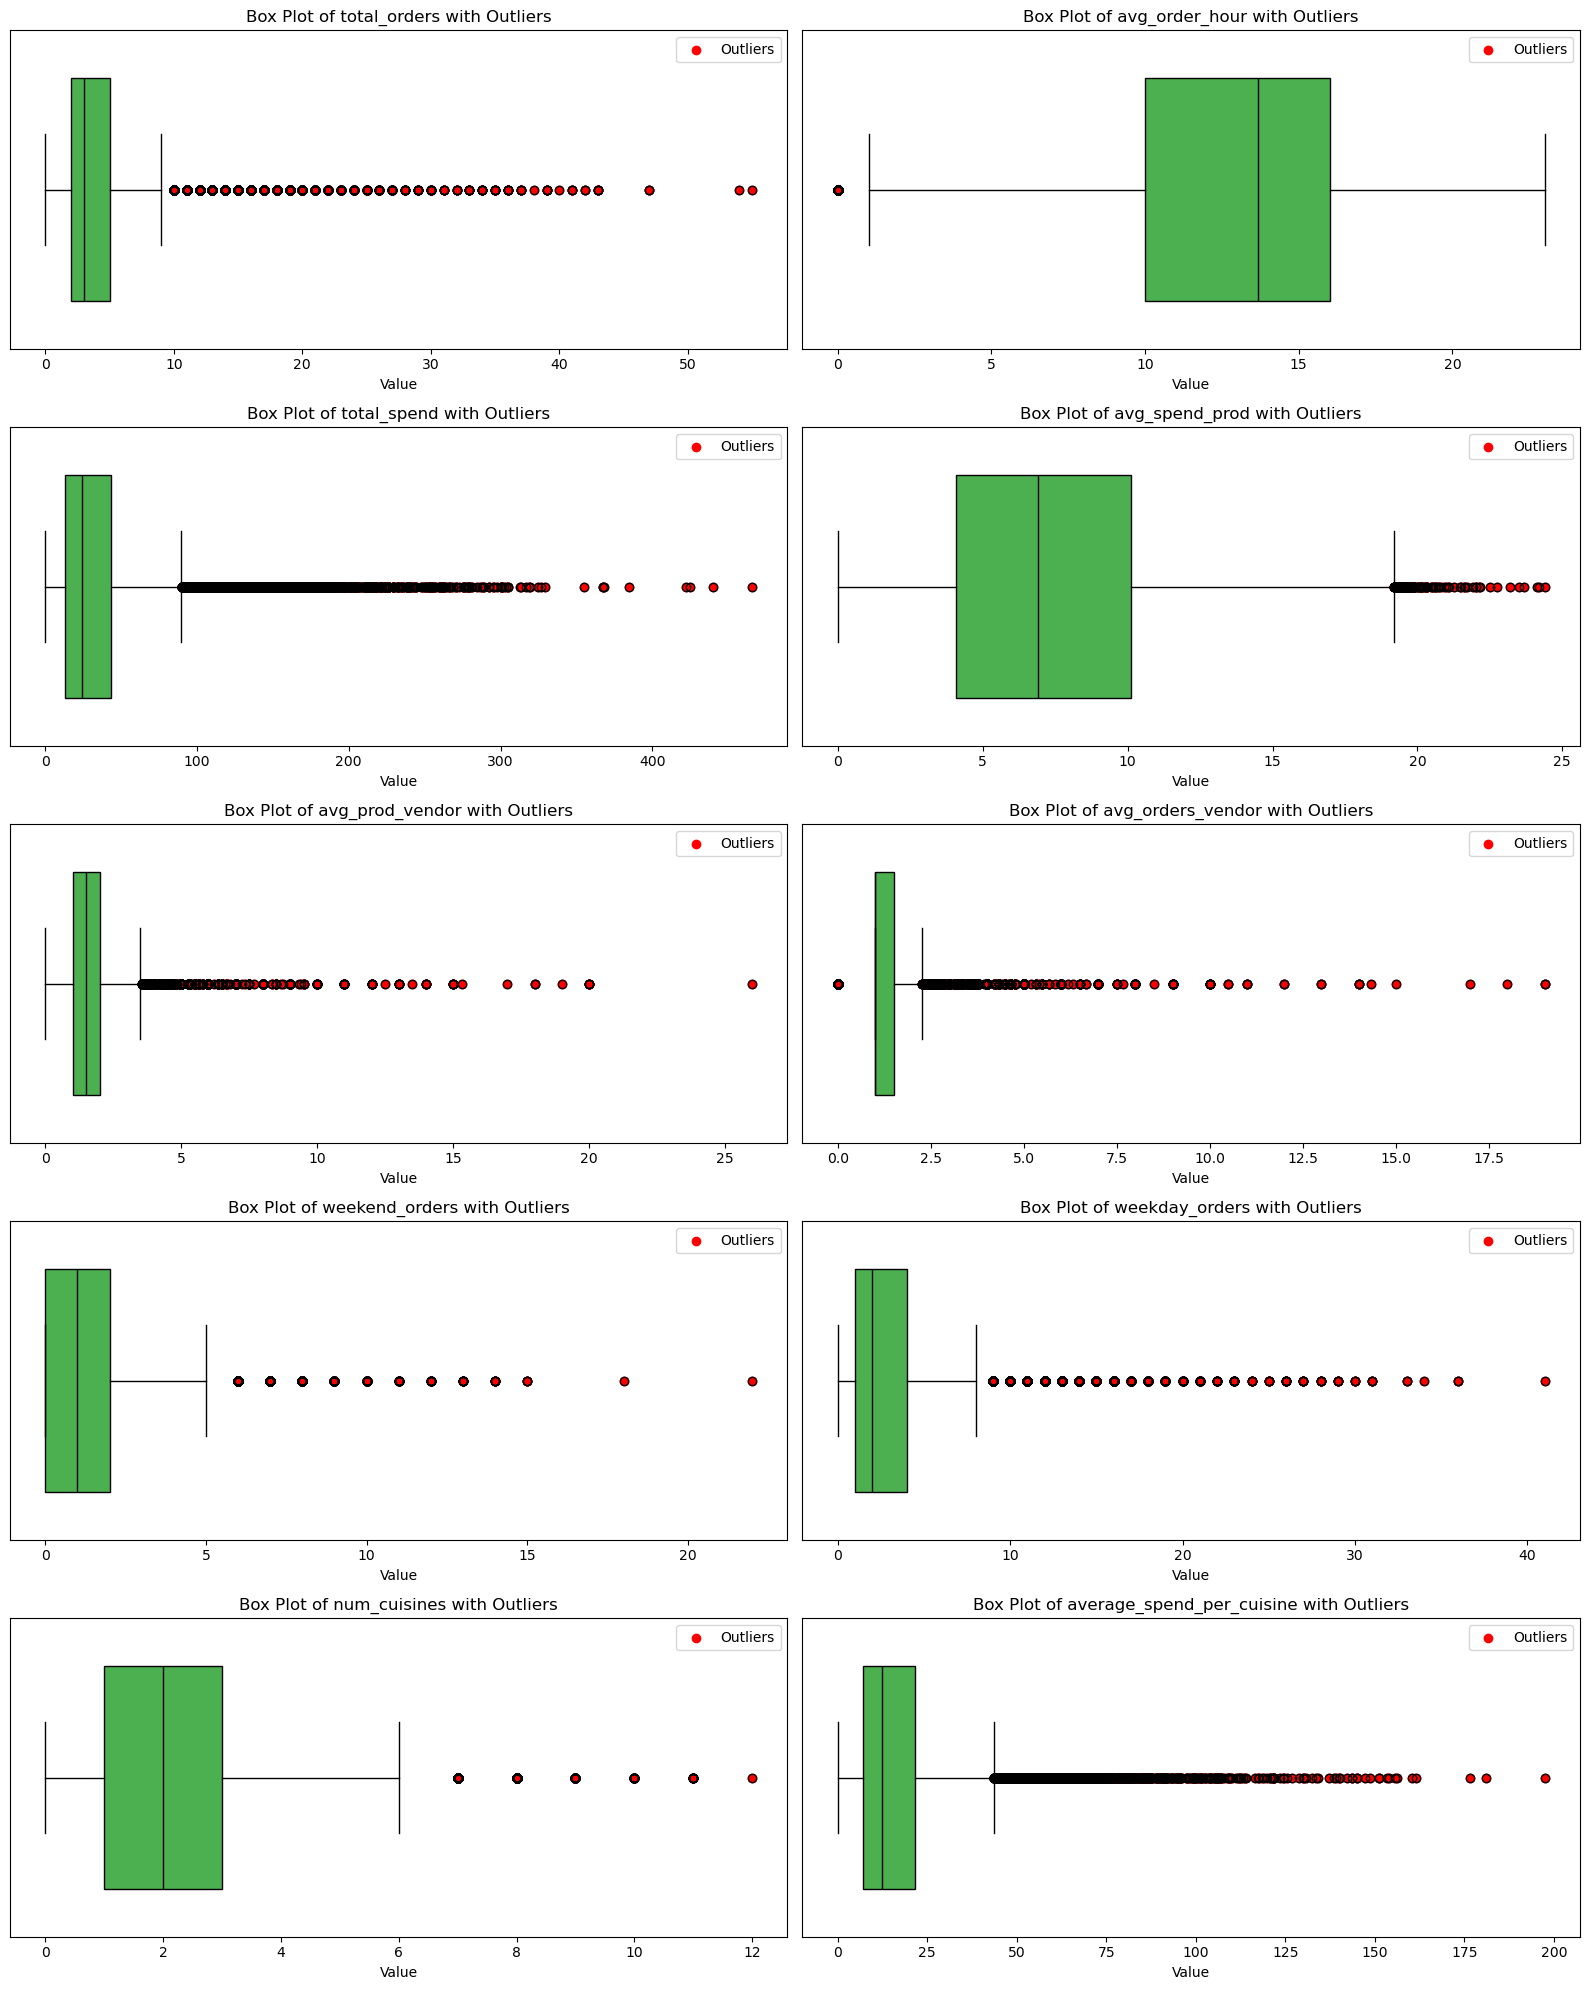

In [87]:
columns = ['total_orders', 'avg_order_hour','total_spend', 'avg_spend_prod', 'avg_prod_vendor', 'avg_orders_vendor',
           'weekend_orders', 'weekday_orders', 'num_cuisines', 'average_spend_per_cuisine']
f.plot_multiple_boxes_with_outliers1(data_copy, columns)

Some of these features have dispersed values. Therefore, we trim them.

In [88]:
data_copy = data_copy[data_copy['total_orders'].le(45)]
data_copy = data_copy[data_copy['avg_order_hour'] != 0]
data_copy = data_copy[data_copy['total_spend'].lt(350)]
data_copy = data_copy[data_copy['avg_prod_vendor'].lt(7)]
data_copy = data_copy[data_copy['avg_orders_vendor'].lt(6)]
data_copy = data_copy[data_copy['weekend_orders'].le(15)]
data_copy = data_copy[data_copy['weekday_orders'].lt(33)]
data_copy = data_copy[data_copy['average_spend_per_cuisine'].lt(175)]

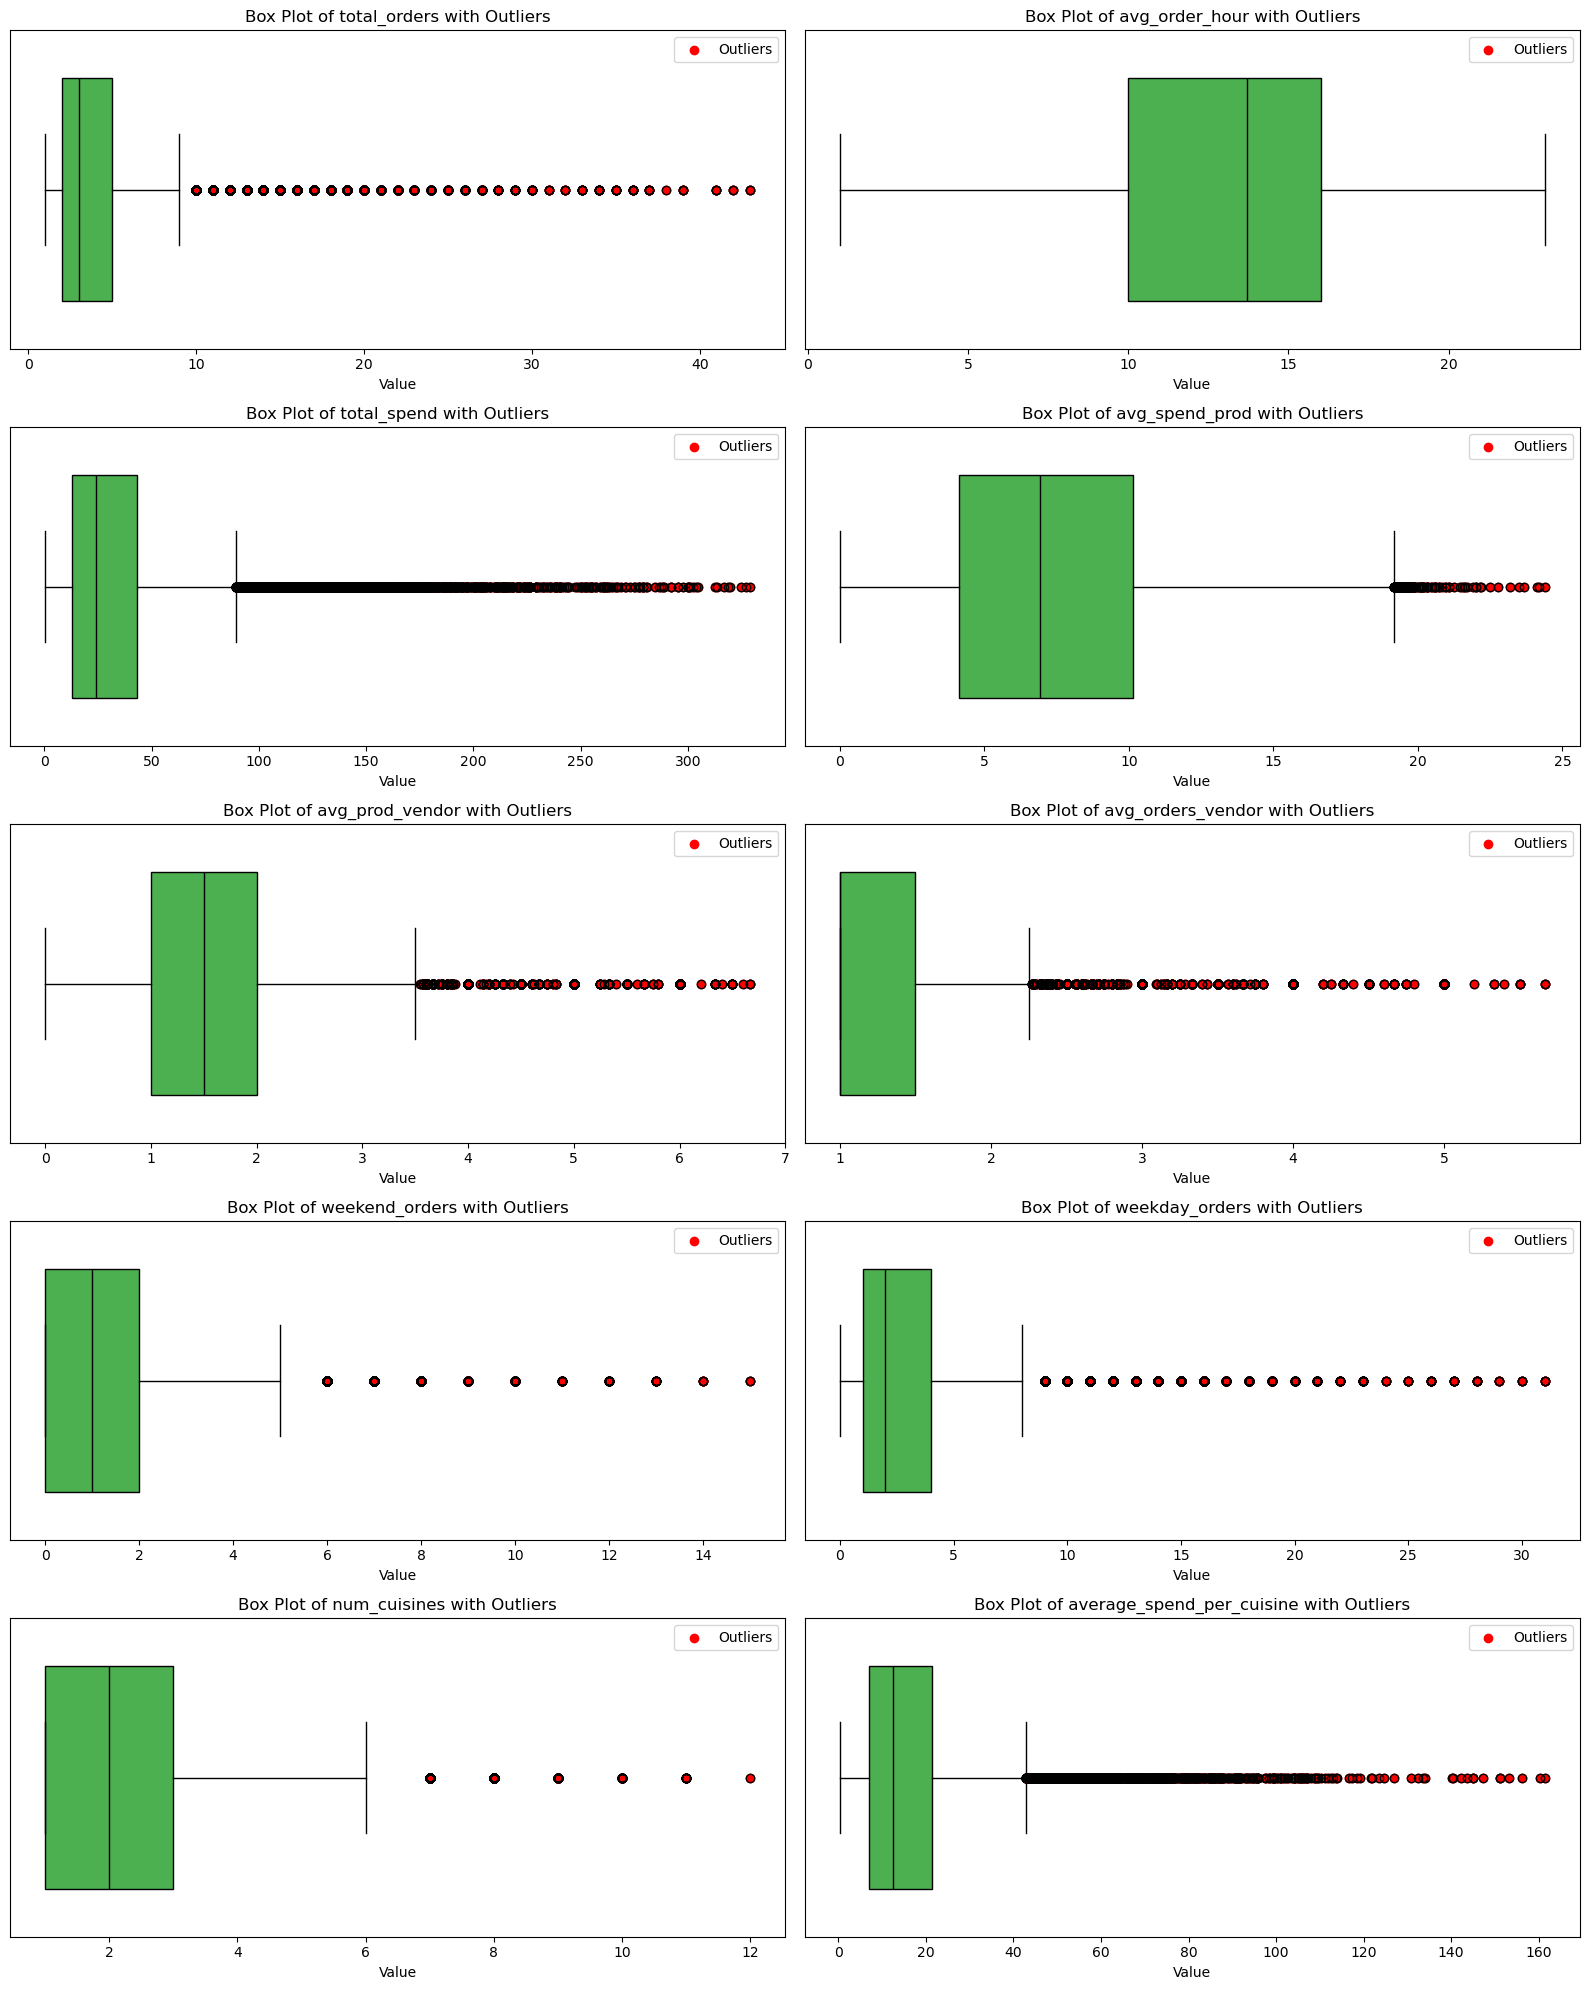

In [89]:
f.plot_multiple_boxes_with_outliers1(data_copy, columns)

<br>

22. Creating a new dataframe to store the outliers

In [90]:
outlier_data = data[~data.isin(data_copy.to_dict(orient='list')).all(axis=1)]

<br>

# 3. Feature Selection

In [91]:
data.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American',
       ...
       'HR_18_ratio', 'HR_19_ratio', 'HR_20_ratio', 'HR_21_ratio',
       'HR_22_ratio', 'HR_23_ratio', '0_7h', '8_14h', '15_19h', '20_23h'],
      dtype='object', length=128)

In [92]:
promo_columns = ['promo_DELIVERY', 'promo_DISCOUNT', 'promo_FREEBIE']
enc_columns = [col_name for col_name in data.columns if 'enc' in col_name] + ['is_repeat_customer']

In [93]:
data_num = data.select_dtypes(include=np.number).set_index(data.index)
data_num.drop(promo_columns + enc_columns, axis = 1, inplace = True)

data_cat = data.select_dtypes(exclude=np.number).set_index(data.index)
data_cat[promo_columns + enc_columns] = data[promo_columns + enc_columns]

<br>

## 3.1. Univariate variables

Here, we are going to check if any of the numerical variables is univariate (variance is equal to 0). Drop those variables if existent.

In [94]:
data_num.var().sort_values()

HR_0_ratio         0.000000
HR_0               0.000000
HR_23_ratio        0.004444
HR_22_ratio        0.005424
HR_1_ratio         0.007181
                   ...     
last_order       539.710501
CUI_Asian        555.608208
first_order      581.628760
days_between     866.590118
total_spend     2153.547644
Length: 119, dtype: float64

None of our variables have a variance of zero, so we do not drop any of them.

<br>

## 3.2 Spearman Correlation

After, we decided to check once more the correlation between our features to conclude which variables are redundant and can be excluded.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


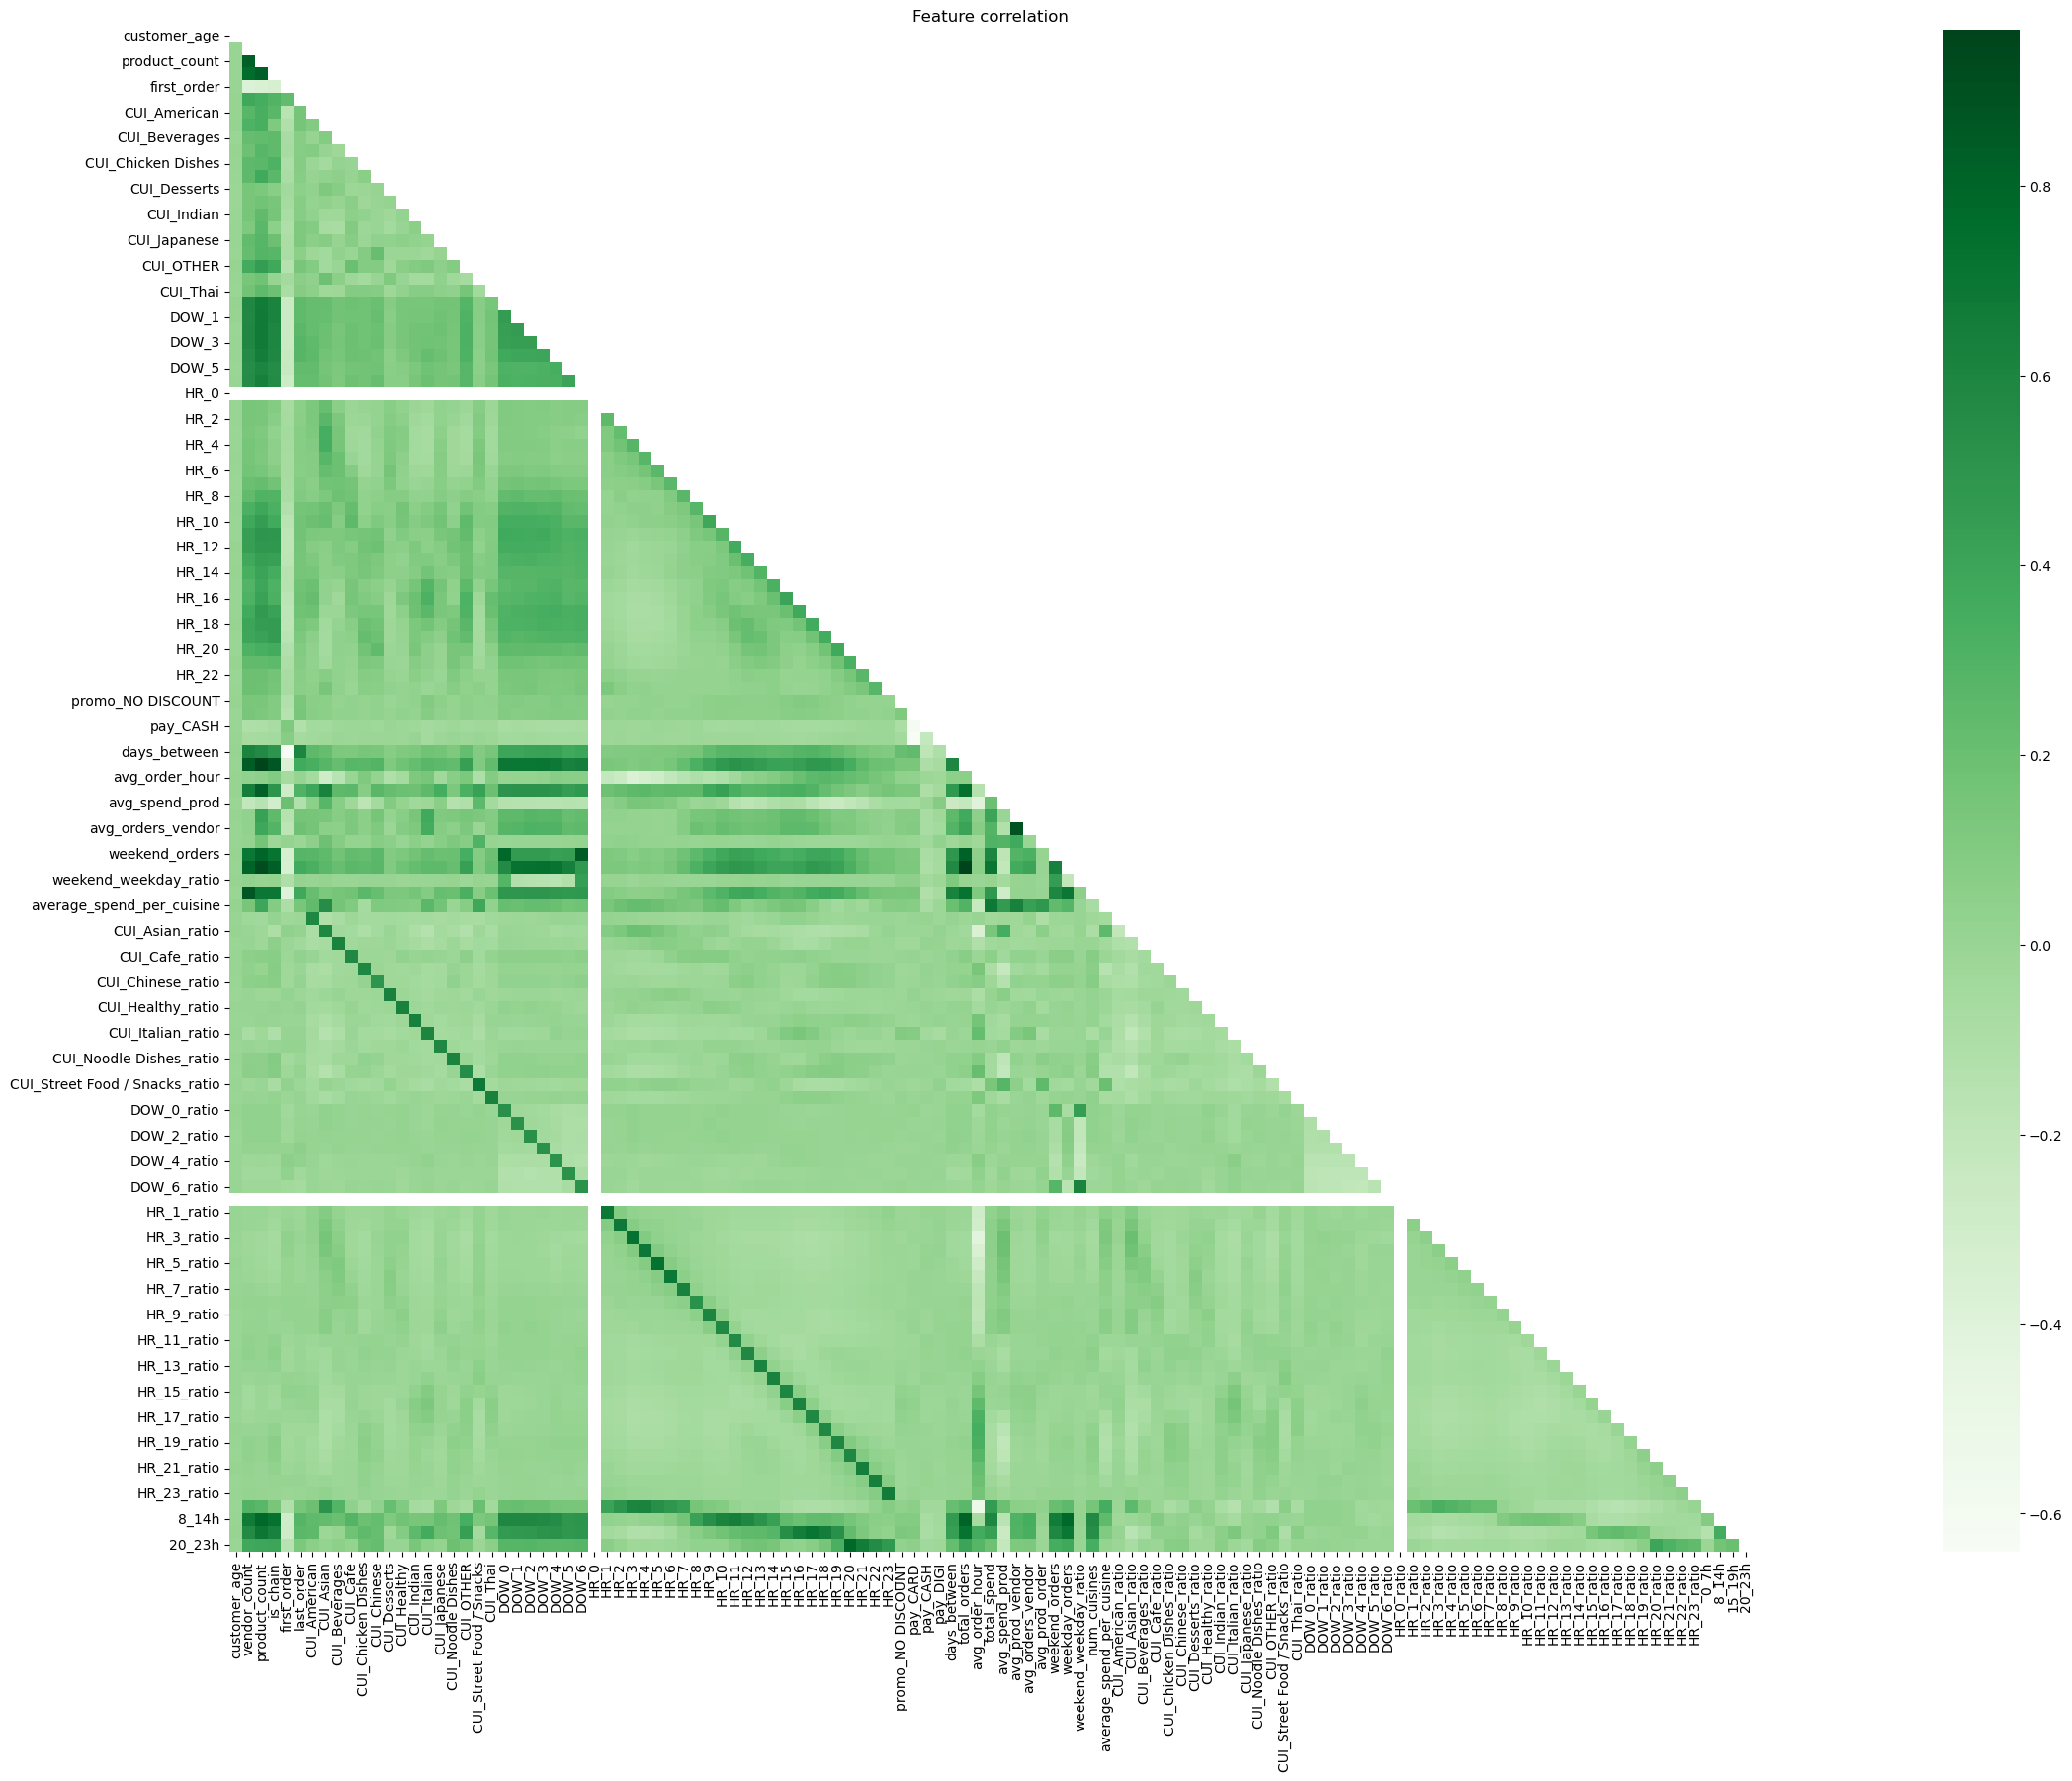

In [95]:
corr = data_num.corr(method="pearson")

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(50, 20))

sns.heatmap(data=corr, annot=True, mask=mask, cmap='Greens', fmt=".2f", square=True)

plt.title('Feature correlation')

plt.show()

Using the threshold of 0.80 (Positive and negative), there are some variables that stand out due to high correlations with several variables. The following are the variables that we can exclude due to high correlations:
* `product_count` is highly correlated to **6** variables which are: `total_orders` (0.97), `weekday_orders` (0.93), `is_chain` (0.83), `vendor_count` (0.83), `total_spend` (0.82) and `weekend_orders` (0.80).
* `total_orders` is highly correlated with **6** variables which are: `product_count` (0.97), `weekday_orders` (0.96), `is_chain` (0.87),`vendor_count` (0.83), `weekend_orders` (0.82) and`8_14h` (0.81).
* `vendor_count` is highly correlated to **3** variables which are: `total_orders` (0.84), `product_count` (0.83) and `weekday_orders` (0.81).
* `is_chain` is highly correlated to **3** variables which are: `total_orders` (0.87), `product_count` (0.83) and `weekday_orders` (0.83).
* `weekday_orders` is highly correlated with **1** variable which is `product_count` (0.93).
* `total_spend` is highly correlated with **1** variable which is `product_count` (0.82).
* `8_14h` is highly correlated with **1** variable which is `total_orders` (0.81).


Above, we can see that most of the correlations involve 2 of the variables: `product_count` and `total_orders`. As such, we should remove these variables. Additionally, we can try to train our models with and without the features `vendor_count` and `is_chain` that show high levels of correlation with 3 other variables.

<br>

## Datasets Overview

In summary we will use the following datasets:

| Dataset Name      | Notes                                    |
|-------------------|------------------------------------------|
| `data_copy`       | Outlier treatment based on data distribution |
| `outlier_data`    | Dataframe with data considered as outlier |




<br>

# 3. Data Export

<a href="#top">Top &#129033;</a>

As a final step in this notebook, we must export the treated dataset to be used in the next phase of the project.

In [96]:
data_copy.to_csv('./data/data_copy.csv', index = True)
outlier_data.to_csv('./data/outlier_data.csv', index = True)

In [29]:
#data_copy.to_csv('./data/data_copy_no_modification.csv', index = True)
#data_capped.to_csv('./data/data_capped.csv', index = True)
#data_log.to_csv('./data/data_with_log.csv', index = True)